In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import ast
import plotly.graph_objects as go
import plotly.offline as py
import plotly
import datetime
from IPython.display import Image, HTML

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats



plotly.offline.init_notebook_mode(connected=True)

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [4]:
movie_df = pd.read_csv('./dataset/movie.csv')
movie_df.head().transpose()

,0,1,2,3,4
movieId,1,2,3,4,5
title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
tmdbId,862,8844,15602,31357,11862
rated,For all ages,For all ages,For all ages,For all ages,For all ages
avg_rating,7.968,7.2,6.466,6.27,6.2
rating_count,18760,10721,395,172,749
runtime,81,104,101,127,106
release_date,1995-11-22,1995-12-15,1995-12-22,1995-12-22,1995-12-08
budget,30000000,65000000,25000000,16000000,0
revenue,394436586,262821940,71500000,81452156,76594107


## Merge genre columms

In [5]:
# Load the secondary dataset that contains genre information
temp_df = pd.read_csv('./dataset/movies.csv')

# Display column names from the temp dataset
print("Columns in temp_df:", temp_df.columns.tolist())

# Show movie_df before merging
print("movie_df before modifications:")
print(movie_df.shape)
print(movie_df.columns.tolist())

# Prepare for merging
if 'movieId' in temp_df.columns:
    # Check if we need to add movieId to movie_df for joining
    if 'movieId' not in movie_df.columns and 'tmdbId' in movie_df.columns:
        # Sometimes movieId corresponds to tmdbId in another dataset
        movie_df['movieId'] = movie_df['tmdbId']
    
    # Extract and process genres
    if 'genres' in temp_df.columns:
        # Create a copy of only needed columns to merge
        merge_df = temp_df[['movieId', 'genres']].copy()
        
        # Parse genres from pipe-separated format
        merge_df['genres_x'] = merge_df['genres'].str.split('|')
        
        # Merge with movie_df
        movie_df = pd.merge(movie_df, merge_df[['movieId', 'genres_x']], 
                           on='movieId', how='left')
        
        # Check if the merge was successful
        print(f"After merge: {movie_df.shape}")
        
        # Add additional columns if they exist
        for col in ['actor', 'director', 'writer']:
            if col in temp_df.columns:
                movie_df = pd.merge(movie_df, 
                                   temp_df[['movieId', col]], 
                                   on='movieId', how='left')
                
                # Convert string representations to lists if needed
                if movie_df[col].dtype == 'object':
                    try:
                        movie_df[col] = movie_df[col].apply(
                            lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
                    except:
                        print(f"Could not parse {col} column as lists")
else:
    print("Warning: 'movieId' not found in temp_df")

# Display the head of movie_df after modifications
movie_df.rename(columns={'genres_x': 'genres'}, inplace=True)
print("\nMovie_df after modifications:")
print(movie_df.shape)
print(movie_df.columns.tolist())
movie_df.head(2).transpose()

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\1436305839.py:2: DtypeWarning:

Columns (4,6,7,8,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.



Columns in temp_df: ['movieId', 'title', 'genres', 'imdbId', 'Rated', 'avg_rating', 'rating_count', 'runtime', 'release_date', 'budget', 'revenue', 'desc', 'status', 'poster', 'language', 'country', 'genre', 'director', 'writer', 'actor']
movie_df before modifications:
(86367, 15)
['movieId', 'title', 'tmdbId', 'rated', 'avg_rating', 'rating_count', 'runtime', 'release_date', 'budget', 'revenue', 'description', 'status', 'poster', 'language', 'country']
After merge: (86367, 16)

Movie_df after modifications:
(86367, 19)
['movieId', 'title', 'tmdbId', 'rated', 'avg_rating', 'rating_count', 'runtime', 'release_date', 'budget', 'revenue', 'description', 'status', 'poster', 'language', 'country', 'genres', 'actor', 'director', 'writer']


,0,1
movieId,1,2
title,Toy Story,Jumanji
tmdbId,862,8844
rated,For all ages,For all ages
avg_rating,7.968,7.2
rating_count,18760,10721
runtime,81,104
release_date,1995-11-22,1995-12-15
budget,30000000,65000000
revenue,394436586,262821940


## Understanding the dataset

In [6]:
movie_df.columns

Index(['movieId', 'title', 'tmdbId', 'rated', 'avg_rating', 'rating_count',
       'runtime', 'release_date', 'budget', 'revenue', 'description', 'status',
       'poster', 'language', 'country', 'genres', 'actor', 'director',
       'writer'],
      dtype='object')

## Features
- movieId: The ID of the movie.
- title: The Official Title of the movie.
- imdbId: The IMDB ID of the movie.
- rated:
- avg_rating:
- rating_count:
- runtime: The runtime of the movie in minutes.
- release_date: Theatrical Release Date of the movie.
- budget: The budget of the movie in dollars.
- revenue: The total revenue of the movie in dollars.
- description: A brief blurb of the movie.
- status: The status of the movie (Released, To Be Released, Announced, etc.)
- poster: The URL of the poster image.
- language: The language in which the movie was originally shot in.
- country:
- genres: A stringified list of dictionaries that list out all the genres associated with the movie.

In [7]:
movie_df.shape

(86367, 19)

In [8]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86367 entries, 0 to 86366
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       86367 non-null  int64  
 1   title         86367 non-null  object 
 2   tmdbId        86367 non-null  int64  
 3   rated         86367 non-null  object 
 4   avg_rating    86367 non-null  float64
 5   rating_count  86367 non-null  int64  
 6   runtime       86367 non-null  int64  
 7   release_date  86367 non-null  object 
 8   budget        86367 non-null  int64  
 9   revenue       86367 non-null  int64  
 10  description   86367 non-null  object 
 11  status        86367 non-null  object 
 12  poster        86367 non-null  object 
 13  language      86367 non-null  object 
 14  country       86367 non-null  object 
 15  genres        86367 non-null  object 
 16  actor         964 non-null    object 
 17  director      965 non-null    object 
 18  writer        950 non-null

## Data Wrangling

Let us start by removing the features that are not useful to us.

In [9]:
movie_df = movie_df.drop(columns=['movieId', 'tmdbId','rated'])

We see that the majority of the movies have a recorded revenue of 0. This indicates that we do not have information about the total revenue for these movies. Although this forms the majority of the movies available to us, we will still use revenue as an extremely important feature going forward from the remaining 7000 moves.

In [10]:
movie_df[movie_df["revenue"]==0].shape

(71169, 16)

In [11]:
movie_df["revenue"] = movie_df["revenue"].replace(0, np.nan)

The budget feature has some unclean values that makes Pandas assign it as a generic object. We proceed to convert this into a numeric variable and replace all the non-numeric values with NaN. Finally, as with budget, we will convert all the values of 0 with NaN to indicate the absence of information regarding budget.

In [12]:
movie_df["budget"] = pd.to_numeric(movie_df["budget"], errors='coerce')
movie_df["budget"] = movie_df["budget"].replace(0, np.nan)
movie_df[movie_df["budget"].isnull()].shape

(70693, 16)

As we move forward trying to answer certain questions, we will have to construct several features suitable for that particular query. For now, we will construct two very important features:

year: The year in which the movie was released.
return: The ratio of revenue to budget.

The return feature is extremely insightful as it will give us a more accurate picture of the financial success of a movie. 

In [13]:
movie_df["return"] = movie_df["revenue"]/movie_df["budget"]
movie_df[movie_df["return"].isnull()].shape

(76397, 17)

In [14]:
movie_df["year"] = pd.to_datetime(movie_df["release_date"], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [15]:
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
movie_df['poster'] = "<img src='" + base_poster_url + movie_df['poster'] + "' style='height:100px;'>"

## Exploratory Data Analysis

### Title and Overview Wordclouds

In [16]:
movie_df['title'] = movie_df['title'].astype('str')
movie_df['description'] = movie_df['description'].astype('str')

In [17]:
title_corpus = ' '.join(movie_df['title'])
description_corpus = ' '.join(movie_df['description'])

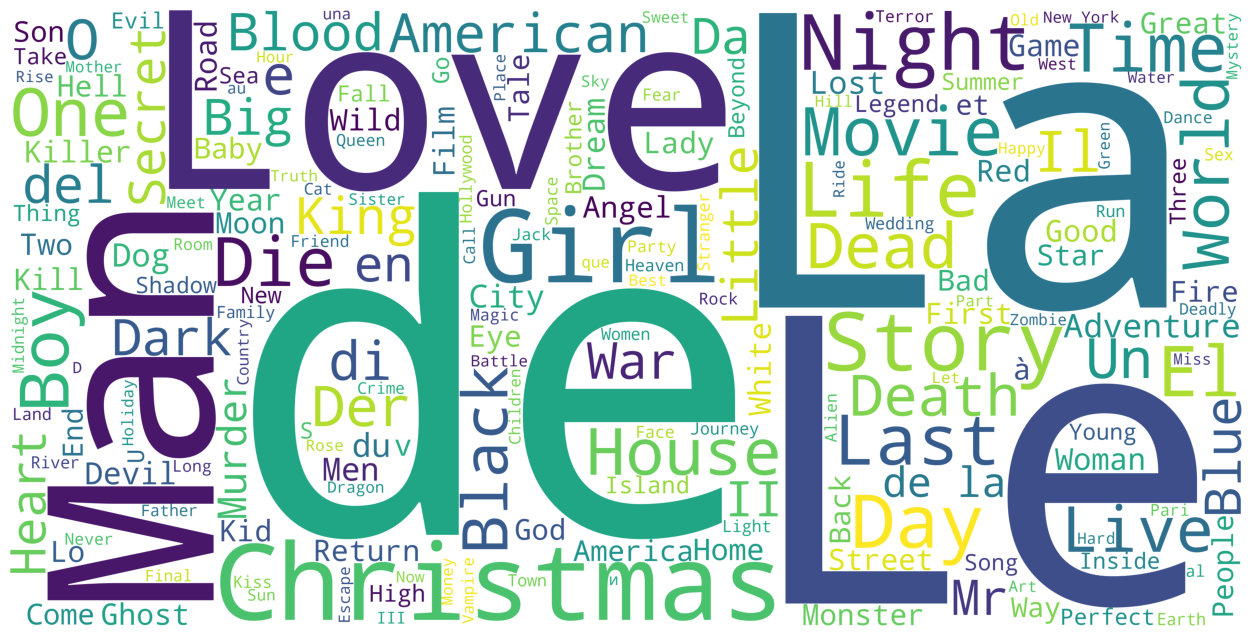

In [18]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

The word Love is the most commonly used word in movie titles. Girl, Day and Man are also among the most commonly occuring words. I think this encapsulates the idea of the ubiquitious presence of romance in movies pretty well.

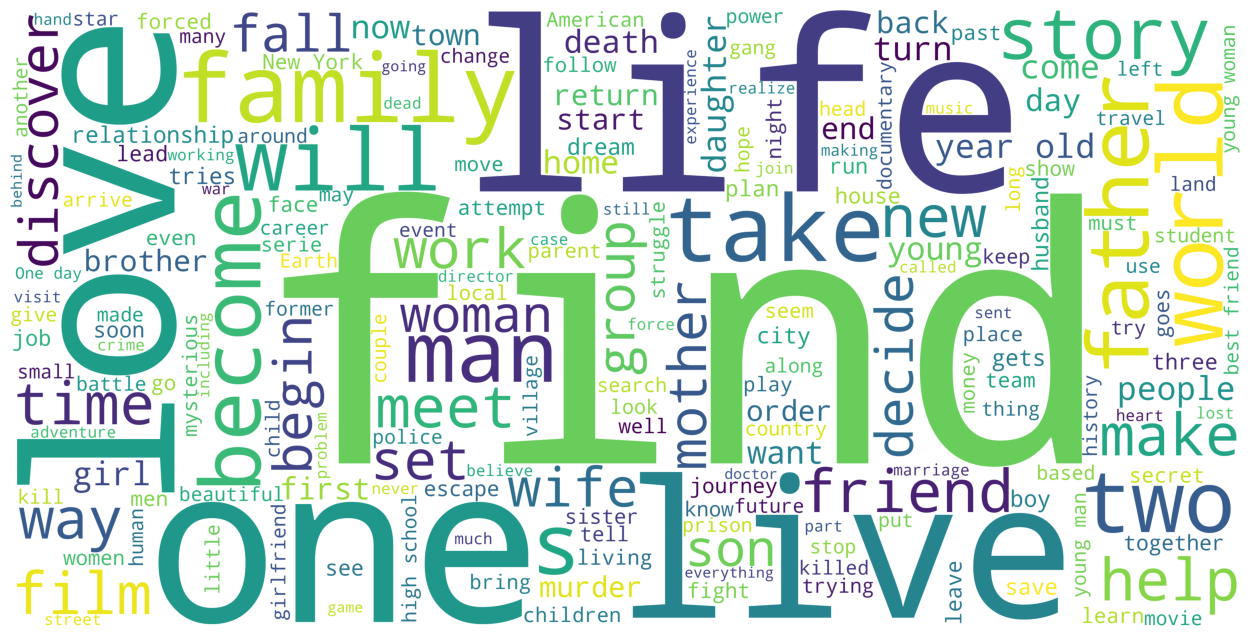

In [19]:
decription_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(description_corpus)
plt.figure(figsize=(16,8))
plt.imshow(decription_wordcloud)
plt.axis('off')
plt.show()

Life is the most commonly used word in Movie titles. One and Find are also popular in Movie Blurbs. Together with Love, Man and Girl, these wordclouds give us a pretty good idea of the most popular themes present in movies.

### Production Countries

In [20]:
country_count = movie_df['country'].value_counts()
country_df = pd.DataFrame(country_count)
country_df = country_df.reset_index()
country_df.columns = ['country', 'count']
country_df

,country,count
0,US,45129
1,FR,5054
2,GB,4116
3,IT,3296
4,JP,2976
...,...,...
162,TJ,1
163,EO,1
164,SV,1
165,TT,1


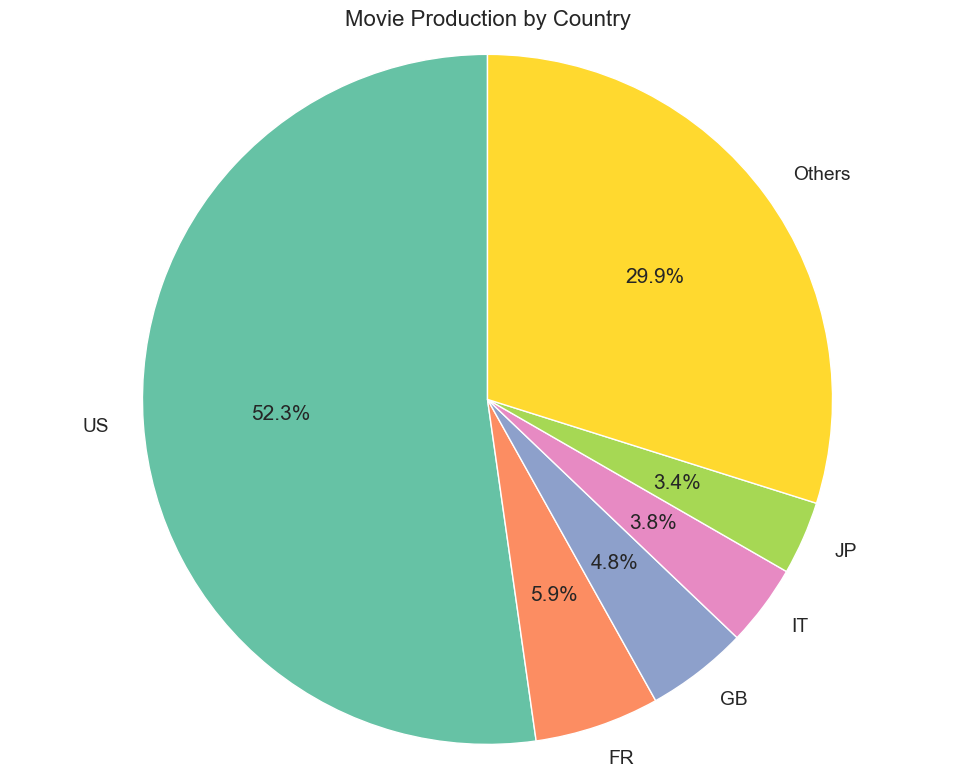

Movie production breakdown by country:
US: 45129 movies (52.3%)
FR: 5054 movies (5.9%)
GB: 4116 movies (4.8%)
IT: 3296 movies (3.8%)
JP: 2976 movies (3.4%)
Others: 25796 movies (29.9%)


In [21]:
# Create a category for other countries
others_count = country_df[country_df.index > 4]['count'].sum()

# Create a new dataframe for the pie chart
pie_data = pd.DataFrame({
    'country': list(country_df.iloc[:5]['country']) + ['Others'],
    'count': list(country_df.iloc[:5]['count']) + [others_count]
})

# Create a pie chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette('Set2')
plt.pie(pie_data['count'], labels=pie_data['country'], autopct='%1.1f%%', 
        startangle=90, shadow=False, colors=colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Movie Production by Country', fontsize=16)
plt.tight_layout()
plt.show()

# Display the data
print("Movie production breakdown by country:")
for i, row in pie_data.iterrows():
    print(f"{row['country']}: {row['count']} movies ({row['count']/sum(pie_data['count'])*100:.1f}%)")



### Original Language

In this section, let us look at the languages of the movies in our dataset. From the production countries, we have already deduced that the majority of the movies in the dataset are English. Let us see what the other major languages represented are.

In [22]:
movie_df['language'].drop_duplicates().shape[0]

123

In [23]:
language_count = movie_df['language'].value_counts()
language_df = pd.DataFrame(language_count)
language_df = language_df.reset_index()
language_df.columns = ['language', 'count']
language_df.head()

,language,count
0,en,54280
1,fr,5136
2,it,3321
3,ja,2953
4,es,2872


There are over 123 languages represented in our dataset. As we had expected, English language films form the overwhelmingly majority. French and Italian movies come at a very distant second and third respectively. Let us represent the most popular languages (apart from English) in the form of a bar plot.

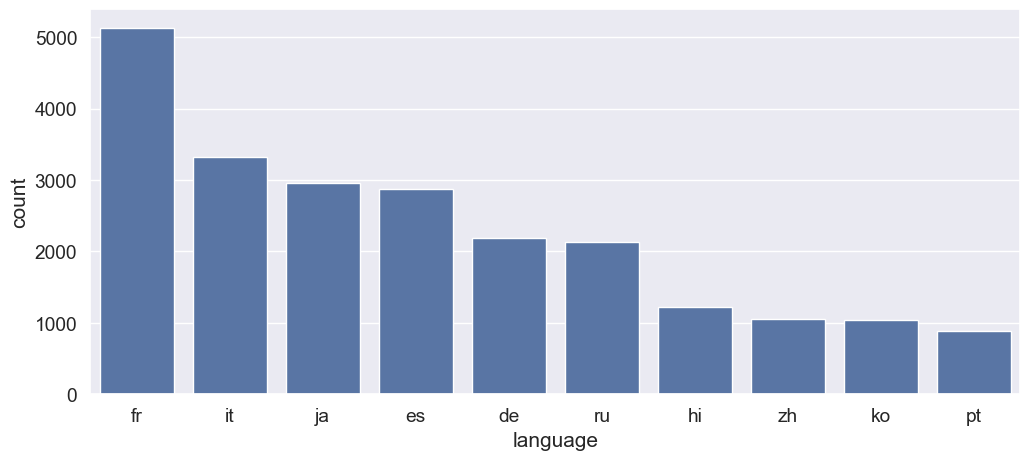

In [24]:
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='count', data=language_df.iloc[1:11])
plt.show()

### Vote Average and Rating Count

In [25]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [26]:
movie_df["avg_rating"] = movie_df["avg_rating"].apply(clean_numeric).astype(float)
movie_df["rating_count"] = movie_df["rating_count"].apply(clean_numeric).astype(float)

In [27]:
movie_df["rating_count"].describe()

count    86367.000000
mean       263.943150
std       1248.624278
min          0.000000
25%          8.000000
50%         23.000000
75%         81.000000
max      37353.000000
Name: rating_count, dtype: float64

Most Voted on Movies

In [28]:
movie_df[["title", "rating_count", "year"]].sort_values(by= 'rating_count', ascending=False).head(10)

,title,rating_count,year
14845,Inception,37353.0,2010
20985,Interstellar,36961.0,2014
12165,The Dark Knight,33727.0,2008
14025,Avatar,32149.0,2009
16954,The Avengers,31590.0,2012
24820,Deadpool,31518.0,2016
24823,Avengers: Infinity War,30418.0,2018
2848,Fight Club,30162.0,1999
292,Pulp Fiction,28570.0,1994
21713,Guardians of the Galaxy,28450.0,2014


Inception and The Dark Knight, two critically acclaimed and commercially successful Christopher Nolan movies figure at the top of our chart.

In [29]:
movie_df["avg_rating"].replace(0, np.nan).describe()

count    84606.000000
mean         5.975860
std          1.168854
min          0.500000
25%          5.300000
50%          6.100000
75%          6.800000
max         10.000000
Name: avg_rating, dtype: float64

<Axes: xlabel='avg_rating', ylabel='Count'>

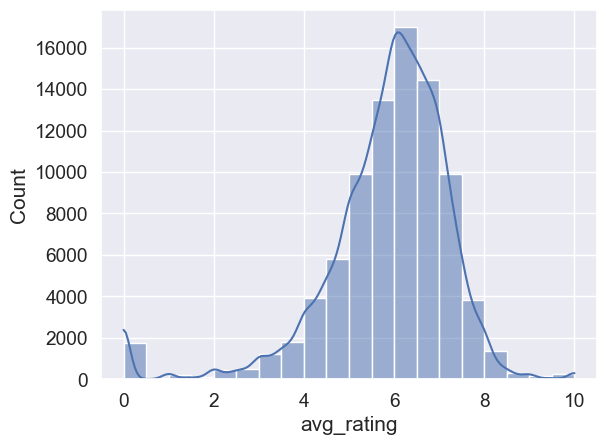

In [30]:
sns.histplot(movie_df["avg_rating"].fillna(movie_df["avg_rating"].median()), kde=True, bins=20)

It appears that TMDB Users are extremely strict in their ratings. The mean rating is only a 5.9 on a scale of 10. Half the movies have a rating of less than or equal to 6. Let us check what the most critically acclaimed movies as per TMDB are. We will only consider those movies that have more than 2000 votes (similar to IMDB's criteria of 5000 votes in selecting its top 250).

Most Critically Acclaimed Movies

In [31]:
movie_df[movie_df["rating_count"] > 2000][['title', 'avg_rating', 'rating_count','year']].sort_values(by='avg_rating', ascending=False).head(10)

,title,avg_rating,rating_count,year
314,The Shawshank Redemption,8.708,28149.0,1994
835,The Godfather,8.687,21339.0,1972
1183,The Godfather Part II,8.570,12900.0,1974
522,Schindler's List,8.564,16366.0,1993
1166,12 Angry Men,8.547,9078.0,1957
5485,千と千尋の神隠し,8.537,17043.0,2001
12165,The Dark Knight,8.519,33727.0,2008
3035,The Green Mile,8.505,18008.0,1999
1916,七人の侍,8.500,3866.0,1954
60200,기생충,8.500,18947.0,2019


The Shawshank Redemption and The Godfather are the two most critically acclaimed movies in the TMDB Database. Interestingly, they are the top 2 movies in IMDB's Top 250 Movies list too. They have a rating of over 9 on IMDB as compared to their 8.6 and 8.7 on TMDB Scores.

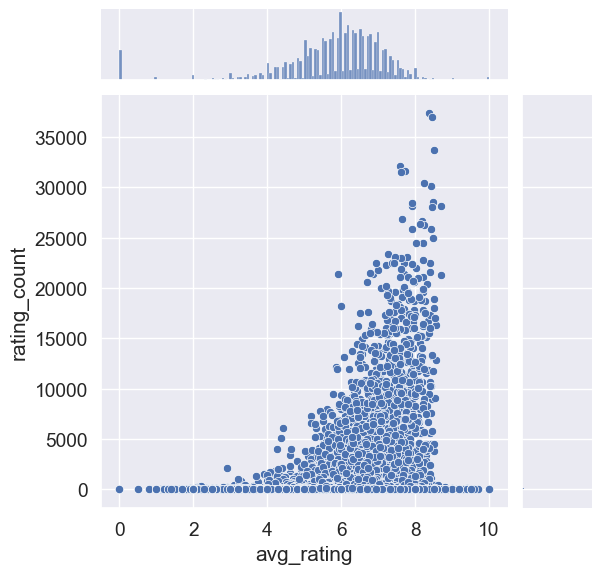

In [32]:
sns.jointplot(x='avg_rating', y='rating_count', data=movie_df)

There is a very small correlation between Vote Count and Vote Average. A large number of votes on a particular movie does not necessarily imply that the movie is good.

Movie Release Dates

In [33]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [34]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan
    
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [35]:
movie_df['month'] = movie_df['release_date'].apply(get_month)
movie_df['day'] = movie_df['release_date'].apply(get_day)

With these features in hand, let us now check the most popular and most successful months and days.

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\1573847797.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: title={'center': 'Number of Movies released in a particular month.'}, xlabel='month', ylabel='count'>

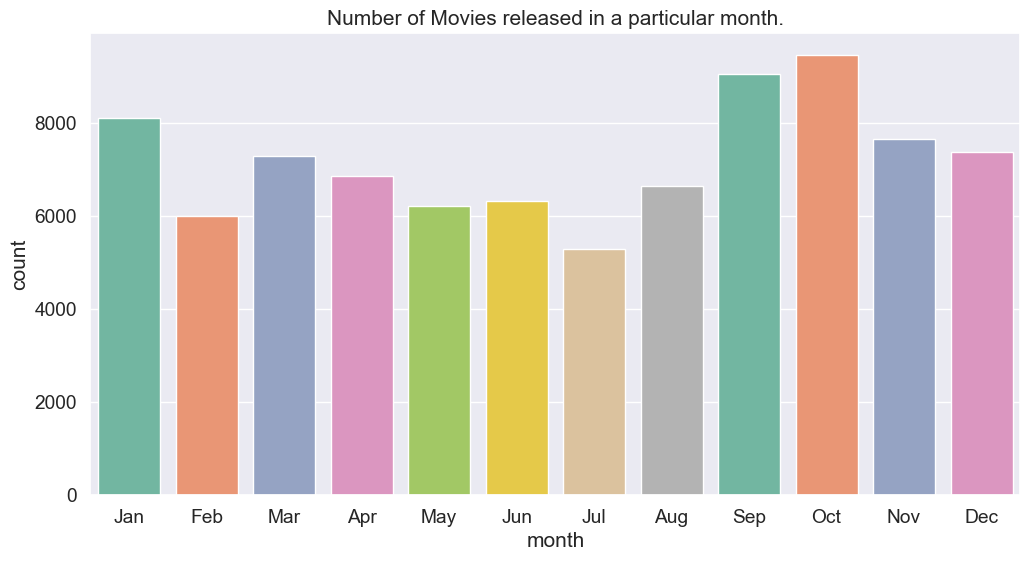

In [36]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=movie_df, order=month_order, palette='Set2')

It appears that October is the most popular month when it comes to movie releases. In Hollywood circles, this is also known as the the dump month when sub par movies are released by the dozen.

In which months do bockbuster movies tend to release? To answer this question, we will consider all movies that have made in excess of 100 million dollars and calculate the average gross for each month.

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\1900434742.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: title={'center': 'Average Gross by the Month for Blockbuster Movies'}, xlabel='mon', ylabel='revenue'>

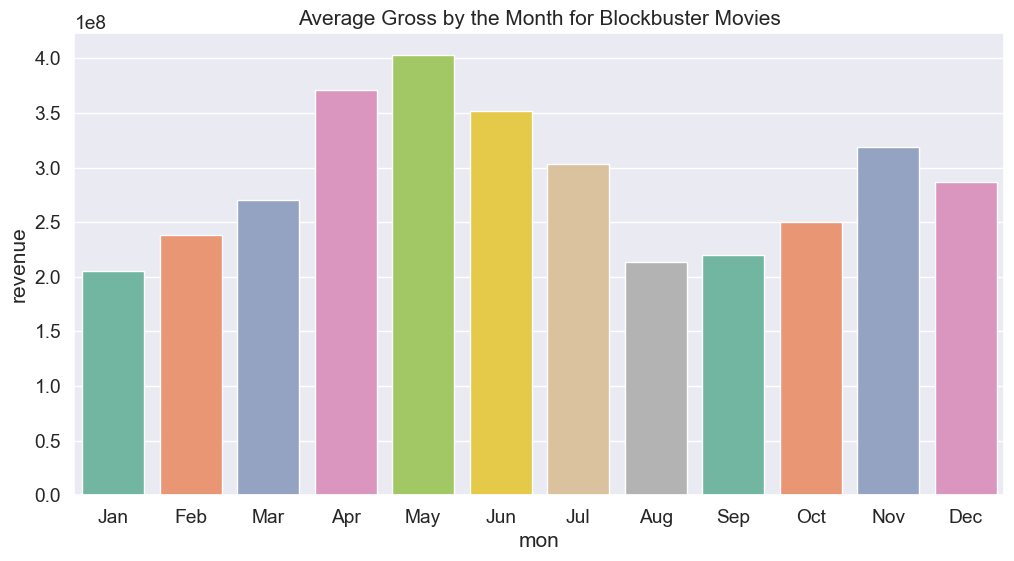

In [37]:
month_mean = pd.DataFrame(movie_df[movie_df['revenue'] > 1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average Gross by the Month for Blockbuster Movies")
sns.barplot(x='mon', y='revenue', data=month_mean, order=month_order, palette='Set2')

We see that the months of April, May and June have the highest average gross among high grossing movies. This can be attributed to the fact that blockbuster movies are usually released in the summer when the kids are out of school and the parents are on vacation and therefore, the audience is more likely to spend their disposable income on entertainment.

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\4060383105.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




(0.0, 12.0)

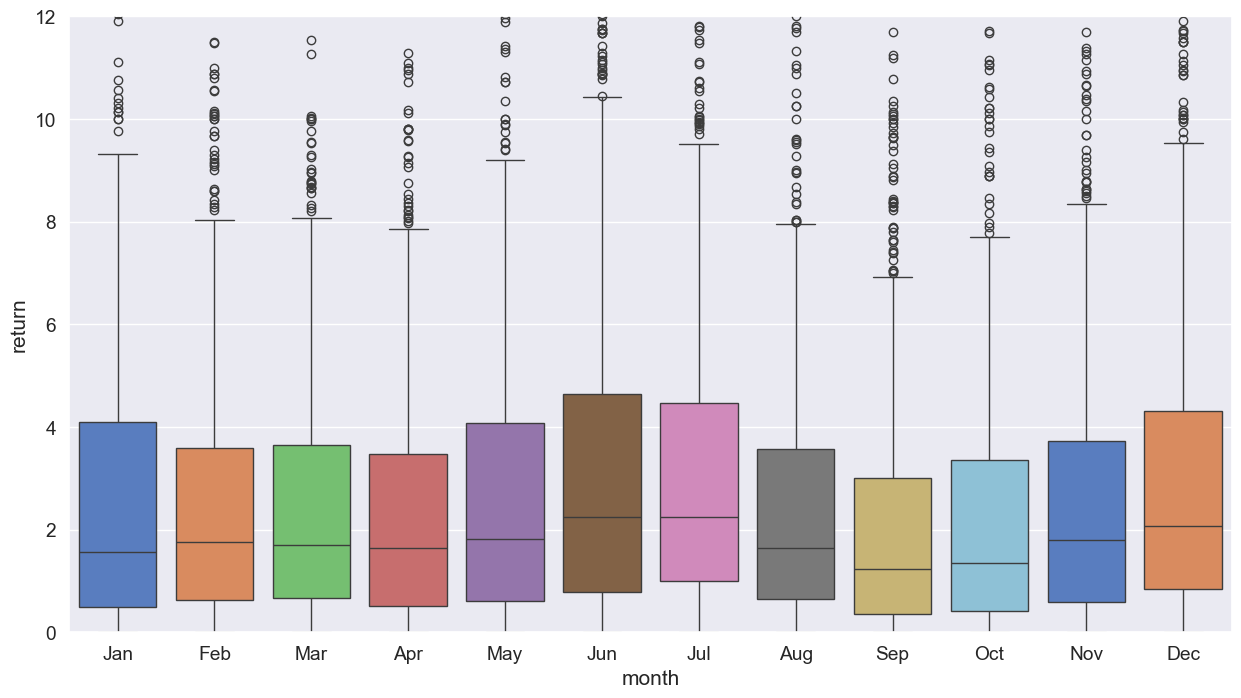

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='month', y='return', data=movie_df[movie_df['return'].notnull()], palette="muted", ax =ax, order=month_order)
ax.set_ylim([0, 12])

The months of June and July tend to yield the highest median returns. September is the least successful months on the aforementioned metrics. Again, the success of June and July movies can be attributed to them being summer months and times of vacation. September usually denotes the beginning of the school/college semester and hence a slight reduction in the consumption of movies.

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\147606228.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: title={'center': 'Number of Movies released on a particular day.'}, xlabel='day', ylabel='count'>

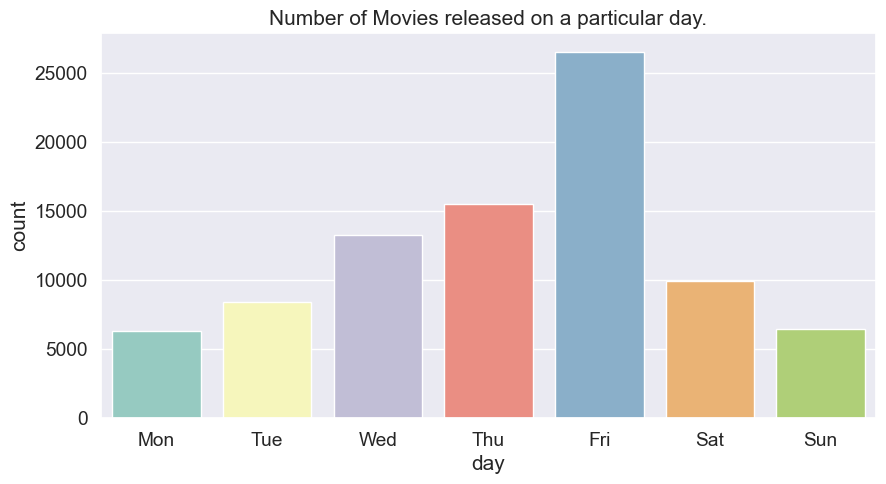

In [39]:
plt.figure(figsize=(10,5))
plt.title("Number of Movies released on a particular day.")
sns.countplot(x='day', data=movie_df, order=day_order, palette='Set3')

Friday is clearly the most popular day for movie releases. This is understandable considering the fact that it usually denotes the beginning of the weekend. Sunday and Monday are the least popular days and this can be attributed to the same aforementioned reason.

 Number of Movies by the year


<Axes: title={'center': 'Number of Movies released in a particular year.'}, xlabel='year'>

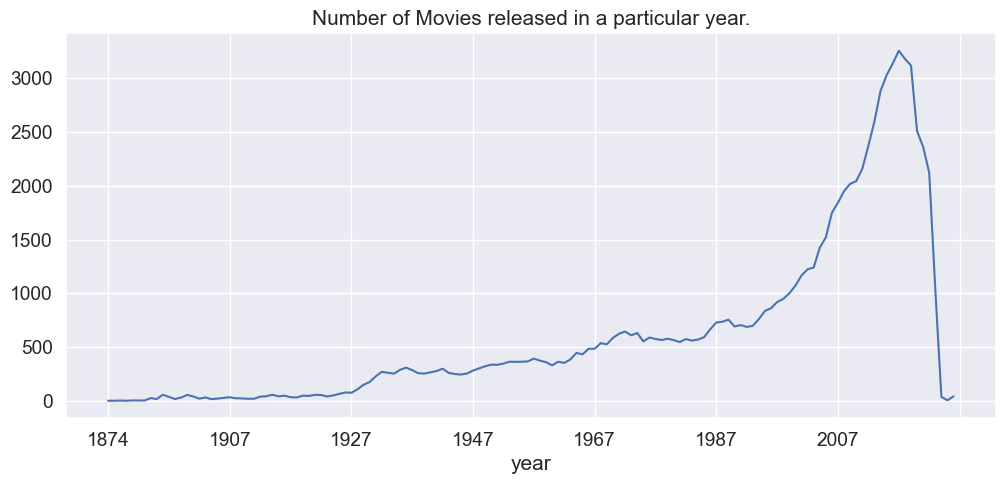

In [40]:
year_count = movie_df.groupby('year')['title'].count()
plt.figure(figsize=(12,5))
plt.title("Number of Movies released in a particular year.")
year_count.plot()

Earliest Movies Represented


In [41]:
movie_df[movie_df['year'] != 'NaT'][['title', 'year']].sort_values('year').head(10)

,title,year
35419,Passage de Venus,1874
35413,Man Walking Around a Corner,1887
35417,Traffic Crossing Leeds Bridge,1888
48374,Roundhay Garden Scene,1888
35414,Accordion Player,1888
76286,"Leisurely Pedestrians, Open Topped Buses and H...",1889
35418,London's Trafalgar Square,1890
41635,"Monkeyshines, No. 3",1890
35416,"Monkeyshines, No. 2",1890
35415,"Monkeyshines, No. 1",1890


The oldest movie, Passage of Venus, wss a series of photographs of the transit of the planet Venus across the Sun in 1874. They were taken in Japan by the French astronomer Pierre Janssen using his 'photographic revolver'. This is also the oldest movie on both IMDB and TMDB.

In [42]:
month = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
         'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [43]:
movie_df_25 = movie_df.copy()
movie_df_25['year'] = movie_df_25[movie_df_25['year'] != 'NaT']['year'].astype(int)
movie_df_25 = movie_df_25[movie_df_25['year'] >=2000]
hmap_25 = pd.pivot_table(data=movie_df_25, index='month', columns='year', aggfunc='count', values='title')
hmap_25 = hmap_25.fillna(0)

<Axes: xlabel='year', ylabel='month'>

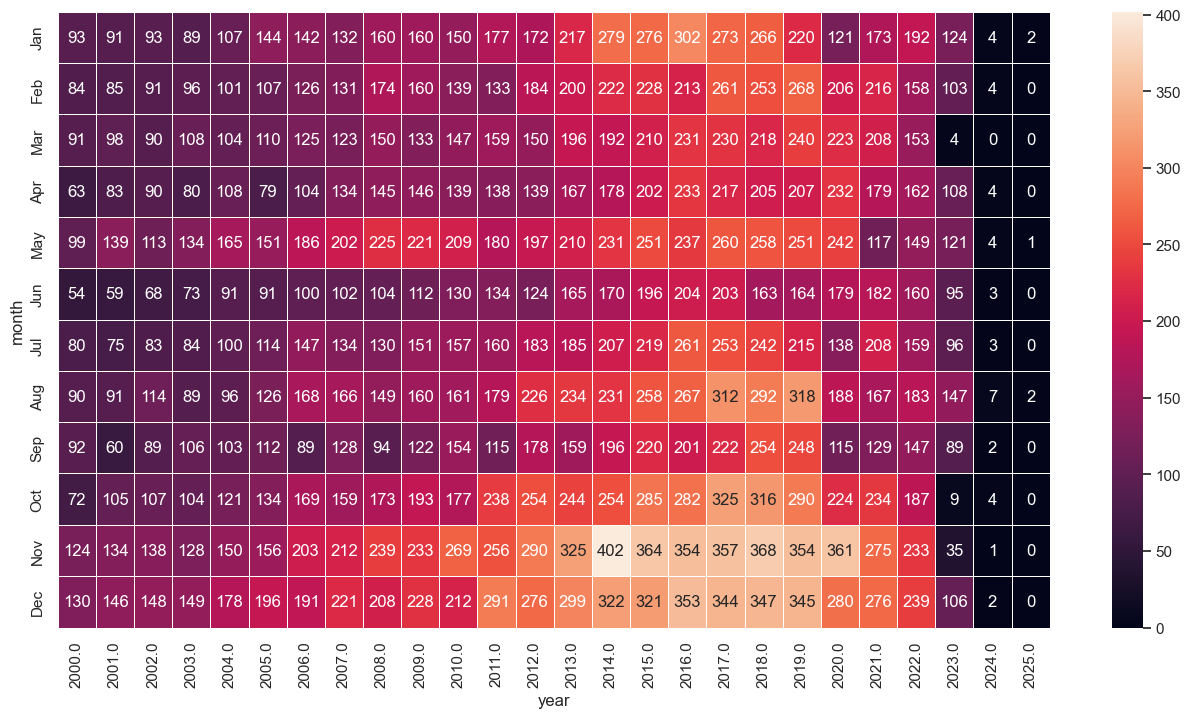

In [44]:
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(hmap_25, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)

In [45]:
sns.set(font_scale=1.25)

### Movie Status

In [46]:
movie_df['status'].value_counts()

status
Released           86360
Post Production        3
Planned                1
In Production          1
Rumored                1
Canceled               1
Name: count, dtype: int64

### Language

In [47]:
movie_df['language'] = movie_df['language'].astype('category').cat.codes
movie_df['language'].value_counts()

language
22     54280
31      5136
45      3321
47      2953
24      2872
       ...  
0          1
109        1
111        1
89         1
51         1
Name: count, Length: 123, dtype: int64

In [48]:
movie_df[movie_df['language'] >= 10][['title','language','year']].sort_values('language', ascending=False).head(10)

,title,language,year
55780,Revenge,122,1985
76900,The Beast,122,2016
68613,The Letter Reader,122,2019
10497,Yesterday,122,2004
61721,过昭关,121,2019
38389,美人鱼,121,2016
60133,飞驰人生,121,2019
49765,青梅竹馬,121,1985
18843,唐山大地震,121,2010
60127,疯狂的外星人,121,2019


### Runtime

In [49]:
movie_df['runtime'].describe()

count    86367.000000
mean        91.456644
std         53.346776
min          0.000000
25%         83.000000
50%         93.000000
75%        105.000000
max      12480.000000
Name: runtime, dtype: float64

The average length of a movie is about 1 hour and 30 minutes. The longest movie on record in this dataset is a staggering 12480 minutes (or 20 hours) long.

In [50]:
movie_df['runtime'] = movie_df['runtime'].astype(float)

<Axes: xlabel='runtime', ylabel='Count'>

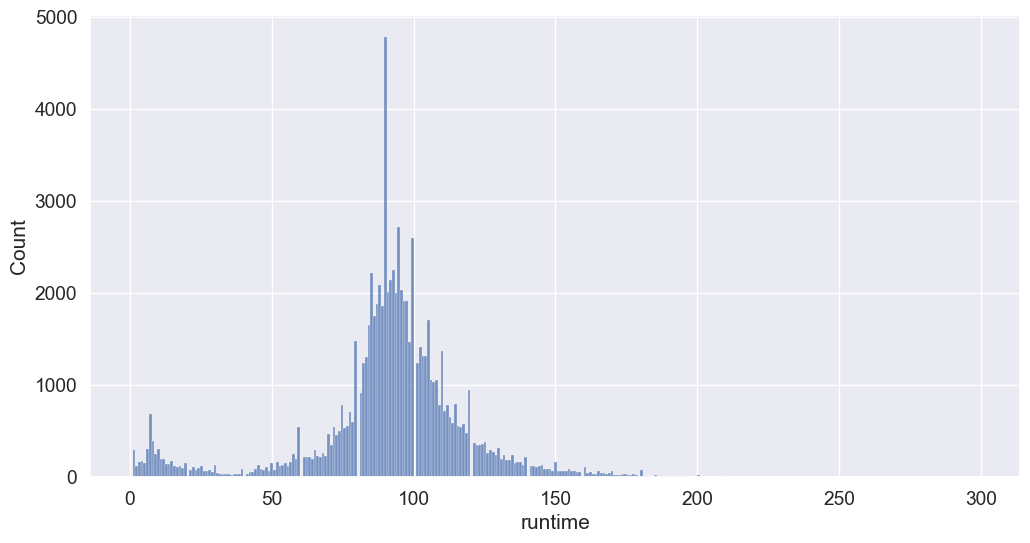

In [51]:
plt.figure(figsize=(12,6))
sns.histplot(movie_df[(movie_df['runtime'] < 300) & (movie_df['runtime'] > 0)]['runtime'])

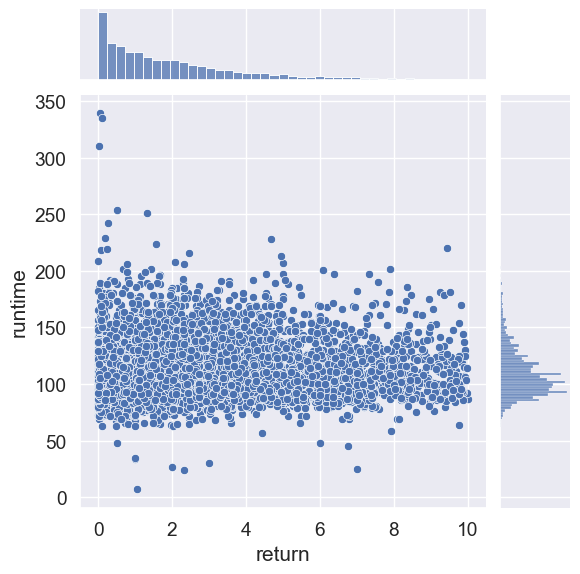

In [52]:
movie_df_mat = movie_df[(movie_df['return'].notnull()) & (movie_df['runtime'] > 0) & (movie_df['return'] < 10)]
sns.jointplot(x='return', y='runtime', data=movie_df_mat)
plt.show()

There seems to be relationship between the two quantities. The duration of a movie is independent of its success. However, I have a feeling this might not be the case with duration and budget. A longer movie should entail a higher budget. Let us find out if this is really the case.

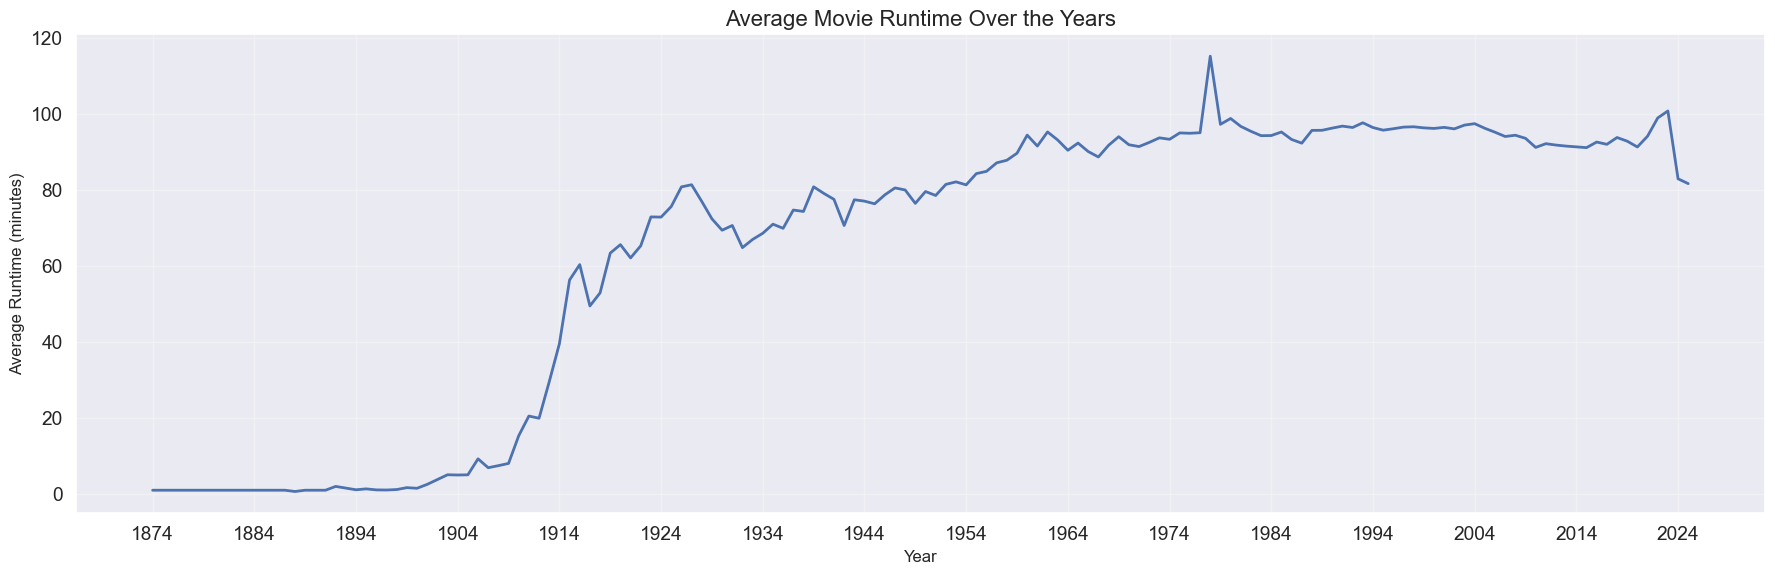

In [53]:
plt.figure(figsize=(18,6))
# Convert index to numeric for proper plotting
year_runtime = movie_df[movie_df['year'] != 'NaT'].groupby('year')['runtime'].mean()
year_runtime.index = pd.to_numeric(year_runtime.index)
year_runtime = year_runtime.sort_index()  # Sort by year

# Plot with numeric years
plt.plot(year_runtime.index, year_runtime.values, linewidth=2)
plt.title('Average Movie Runtime Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Runtime (minutes)', fontsize=12)

# Set x-axis ticks and labels at regular intervals
years = np.arange(int(min(year_runtime.index)), int(max(year_runtime.index))+1, 10)
plt.xticks(years)

# Add grid for better readability
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Shortest movie

In [54]:
movie_df[movie_df['runtime'] > 0][['title', 'runtime', 'year']].sort_values('runtime').head(10)

,title,runtime,year
69031,Les krémos: Sauts perilleux,1.0,1899
50993,Eye Myth,1.0,1967
64249,"The Boys Think They Have One on Foxy Grandpa, ...",1.0,1902
50994,Bataille de neige,1.0,1897
50996,"Arroseur et arrosé, III",1.0,1897
71466,How It Feels to Be Run Over,1.0,1900
50999,The Gay Shoe Clerk,1.0,1903
59815,Persian Series #11,1.0,2000
77660,Tom Whisky ou L'illusioniste toqué,1.0,1900
77661,La vengeance du gâte-sauce,1.0,1900


We see that every movie in this list except Persian Series #11 were filmed in the late 1890s and the beginning of the 20th century. All these movies were one minute long.

Longest Movies

In [55]:
movie_df[movie_df['runtime'] > 0][['title', 'runtime', 'year']].sort_values('runtime', ascending=False).head(10)

,title,runtime,year
72503,Cinématon,12480.0,1978
49565,The Reality of Me,840.0,2012
75767,Music with Roots in the Aether: Opera for Tele...,840.0,1974
59220,La flor,803.0,2019
53226,Out 1,743.0,1990
63770,Ebolusyon ng Isang Pamilyang Pilipino,625.0,2004
52663,Kingdom Hospital,608.0,2004
35108,The Untold History Of The United States,585.0,2012
76416,Nachrichten aus der ideologischen Antike: Marx...,570.0,2008
6749,Shoah,566.0,1985


### Budget

In [56]:
movie_df['budget'].describe()

count    1.567400e+04
mean     1.717579e+07
std      3.219252e+07
min      1.000000e+00
25%      1.000000e+06
50%      5.000000e+06
75%      1.900000e+07
max      4.600000e+08
Name: budget, dtype: float64

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\1813006074.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='budget', ylabel='Density'>

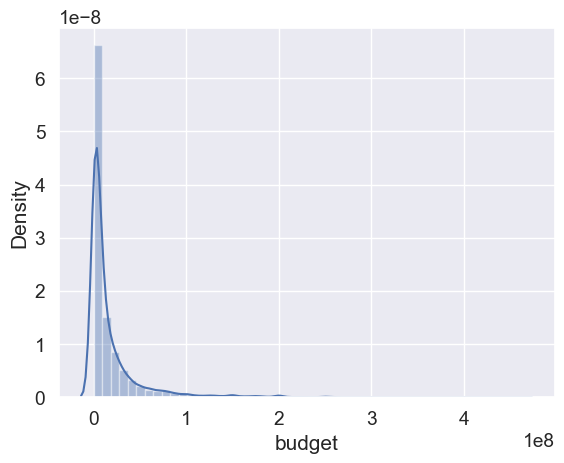

In [57]:
sns.distplot(movie_df[movie_df['budget'].notnull()]['budget'])

<Axes: title={'center': 'Budget Distribution (Log Scale)'}, ylabel='Frequency'>

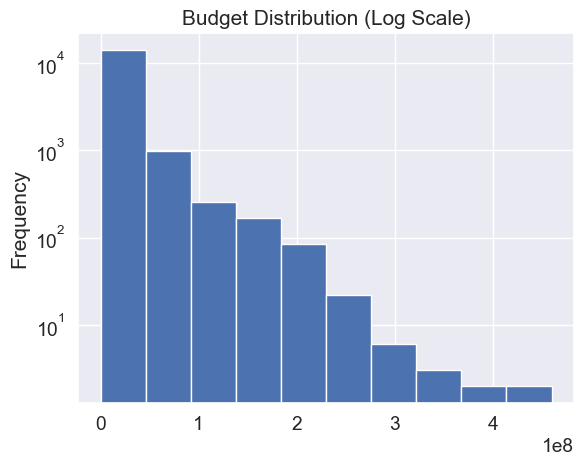

In [58]:
movie_df['budget'].plot(logy= True, kind = 'hist', title='Budget Distribution (Log Scale)')

The distribution of movie budgets shows an exponential decay. More than 75% of the movies have a budget smaller than 25 million dollars. Next, let us take a look at the most expensive movies of all time and the revenue & returns that they generated.

Most Expensive Movies of all Time


In [59]:
movie_df[movie_df['budget'].notnull()][['title', 'budget','revenue','return', 'year']].sort_values('budget', ascending=False).head(10)

,title,budget,revenue,return,year
82472,Avatar: The Way of Water,460000000.0,2.320250e+09,5.044022,2022
62698,Star Wars: The Rise of Skywalker,416000000.0,1.074144e+09,2.582078,2019
83233,Ant-Man and the Wasp: Quantumania,388369742.0,4.760712e+08,1.225819,2023
16331,Pirates of the Caribbean: On Stranger Tides,379000000.0,1.046721e+09,2.761798,2011
24815,Avengers: Age of Ultron,365000000.0,1.405404e+09,3.850421,2015
24824,Avengers: Endgame,356000000.0,2.799439e+09,7.863593,2019
84840,Fast X,340000000.0,7.047097e+08,2.072675,2023
24823,Avengers: Infinity War,300000000.0,2.052415e+09,6.841383,2018
24817,Justice League,300000000.0,6.613270e+08,2.204423,2017
11556,Pirates of the Caribbean: At World's End,300000000.0,9.616912e+08,3.205637,2007


Avatar: The Way of Water films occupy the top spots in this list with a staggering budget of over 300 million dollars. All the top 10 most expensive films made a profit on their investment

Text(0.5, 1.02, 'Relationship between Budget and Revenue')

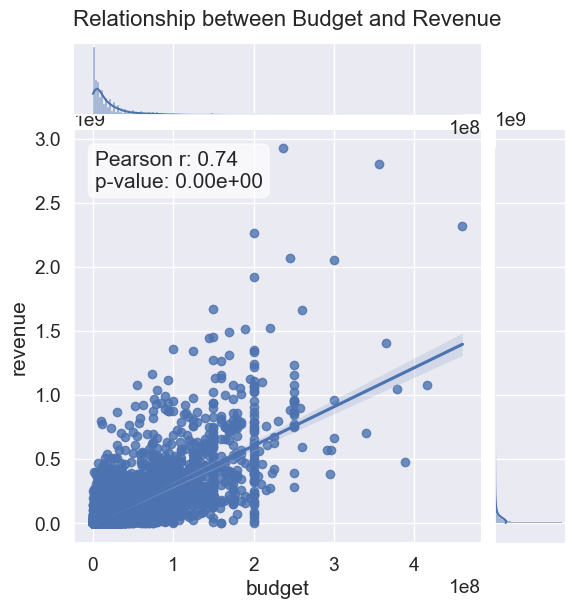

In [60]:
import scipy.stats as stats

# Create joint plot with correlation statistics
g = sns.jointplot(x='budget', y='revenue', data=movie_df[movie_df['return'].notnull()], kind='reg')

# Calculate Pearson correlation coefficient and p-value
pearson_r, p_value = stats.pearsonr(
    movie_df[movie_df['return'].notnull()]['budget'], 
    movie_df[movie_df['return'].notnull()]['revenue']
)

# Add correlation information to the plot
g.ax_joint.annotate(f'Pearson r: {pearson_r:.2f}\np-value: {p_value:.2e}', 
                   xy=(0.05, 0.95), xycoords='axes fraction',
                   ha='left', va='top',
                   bbox=dict(boxstyle='round', fc='white', alpha=0.7))

# Add a title
g.fig.suptitle('Relationship between Budget and Revenue', y=1.02, fontsize=16)

The pearson r value of 0.74 between the two quantities indicates a very strong correlation.



Revenue

In [61]:
movie_df['revenue'].describe()

count    1.519800e+04
mean     4.745605e+07
std      1.306188e+08
min      1.000000e+00
25%      9.785000e+05
50%      6.800000e+06
75%      3.359579e+07
max      2.923706e+09
Name: revenue, dtype: float64

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\1974120642.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='revenue', ylabel='Density'>

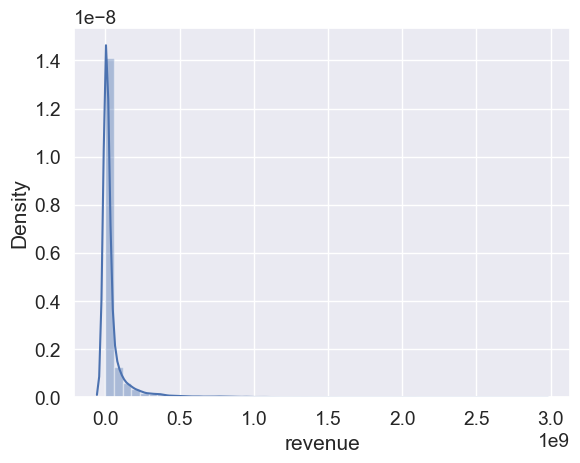

In [62]:
sns.distplot(movie_df[movie_df['revenue'].notnull()]['revenue'])

The distribution of revenue undergoes exponential decay just like budget. We also found that the two quantities were strongly correlated. Let us now take a look at the highest and least grossing movies of all time.

In [63]:
gross_top = movie_df[['poster', 'title', 'budget', 'revenue', 'year']].sort_values('revenue', ascending=False).head(10)
pd.set_option('display.max_colwidth', 100)
HTML(gross_top.to_html(escape=False))

,poster,title,budget,revenue,year
14025,,Avatar,237000000.0,2.923706e+09,2009
24824,,Avengers: Endgame,356000000.0,2.799439e+09,2019
82472,,Avatar: The Way of Water,460000000.0,2.320250e+09,2022
1644,,Titanic,200000000.0,2.264162e+09,1997
24812,,Star Wars: The Force Awakens,245000000.0,2.068224e+09,2015
24823,,Avengers: Infinity War,300000000.0,2.052415e+09,2018
77557,,Spider-Man: No Way Home,200000000.0,1.921847e+09,2021
23015,,Jurassic World,150000000.0,1.671537e+09,2015
60548,,The Lion King,260000000.0,1.662021e+09,2019
16954,,The Avengers,220000000.0,1.518816e+09,2012


In [64]:
pd.set_option('display.max_colwidth', 50)

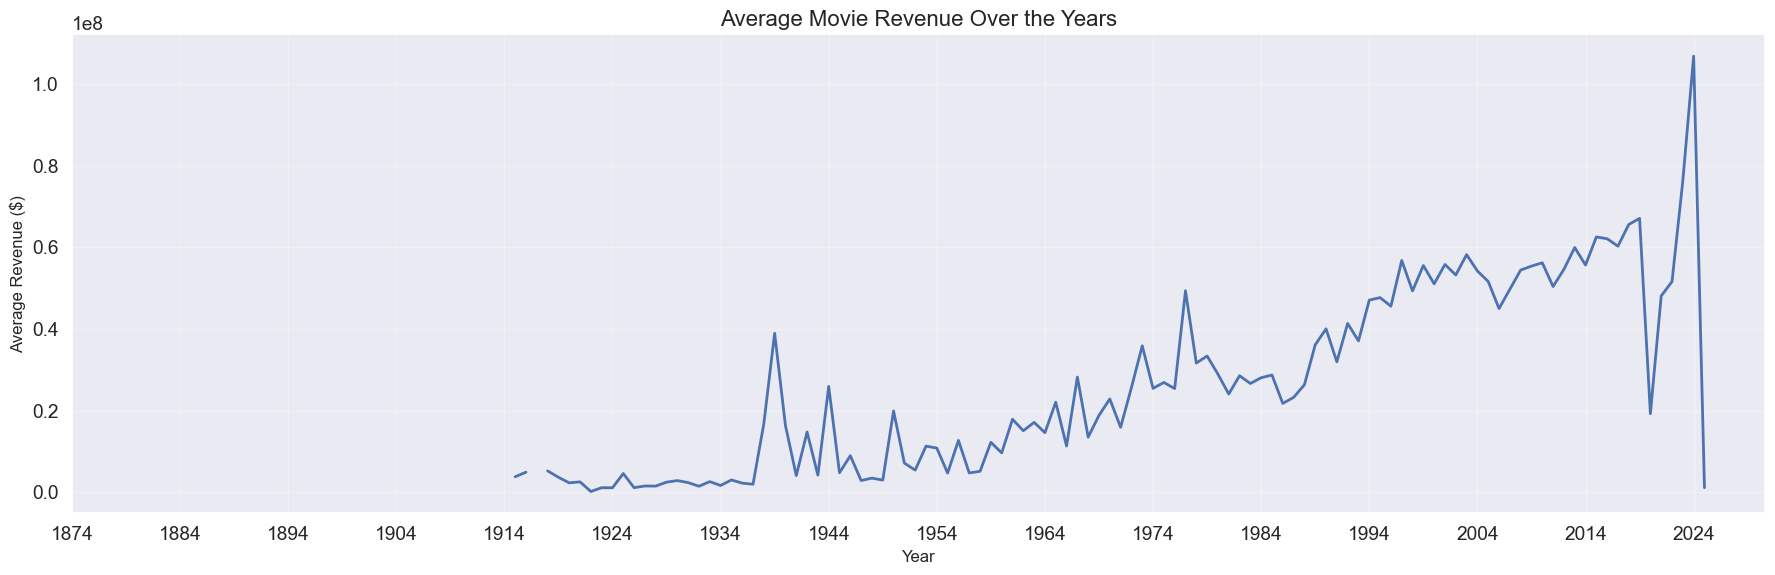

In [65]:
plt.figure(figsize=(18,6))
# Convert index to numeric for proper plotting
year_revenue = movie_df[movie_df['year'] != 'NaT'].groupby('year')['revenue'].mean()
year_revenue.index = pd.to_numeric(year_revenue.index)
year_revenue = year_revenue.sort_index()  # Sort by year

# Plot with numeric years
plt.plot(year_revenue.index, year_revenue.values, linewidth=2)
plt.title('Average Movie Revenue Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Revenue ($)', fontsize=12)

# Set x-axis ticks and labels at regular intervals
years = np.arange(int(min(year_revenue.index)), int(max(year_revenue.index))+1, 10)
plt.xticks(years)

# Add grid for better readability
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Return

We will not look too much into returns for the time being. Let us just check the least and the most successful movies of all time. To do this, we will only consider those movies which have a budget greater than 5 million dollars.

Most Successful Movies


In [66]:
movie_df[(movie_df['return'].notnull()) & (movie_df['budget'] > 5e6)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return', ascending=False).head(10)

,title,budget,revenue,return,year
1065,E.T. the Extra-Terrestrial,10500000.0,792965500.0,75.520524,1982
257,Star Wars,11000000.0,775398007.0,70.490728,1977
1343,Jaws,7000000.0,470653000.0,67.236143,1975
1336,Grease,6000000.0,396271103.0,66.045184,1978
835,The Godfather,6000000.0,245066411.0,40.844402,1972
22172,Annabelle,6500000.0,257589952.0,39.629223,2014
4495,Look Who's Talking,7500000.0,297000000.0,39.600000,1989
7881,Fahrenheit 9/11,6000000.0,222400000.0,37.066667,2004
1894,The Exorcist,12000000.0,441306145.0,36.775512,1973
1056,Dirty Dancing,6000000.0,214577242.0,35.762874,1987


Worst Box Office Disasters

In [67]:
movie_df[(movie_df['return'].notnull()) & (movie_df['budget'] > 5e6) & (movie_df['revenue'] > 10000)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return').head(10)

,title,budget,revenue,return,year
82351,White Noise,100000000.0,71476.0,0.000715,2022
30984,Accidental Love,26000000.0,24487.0,0.000942,2015
70128,Sir Billi,15000000.0,15838.0,0.001056,2012
77210,Red Notice,160000000.0,178143.0,0.001113,2021
23743,Foodfight!,65000000.0,73706.0,0.001134,2012
72173,승리호,21000000.0,24571.0,0.001170,2021
68055,"The Tulse Luper Suitcases, Part 3: From Sark t...",10000000.0,12000.0,0.001200,2004
39660,Term Life,16500000.0,21256.0,0.001288,2016
45997,Lady Bloodfight,10000000.0,13109.0,0.001311,2016
3969,Cherry 2000,10000000.0,14000.0,0.001400,1987


In [68]:
movie_df['year'] = movie_df['year'].replace('NaT', np.nan)
movie_df['year'] = movie_df['year'].apply(clean_numeric)

With these analyses in place, we are in a good position to construct our correlation matrix.

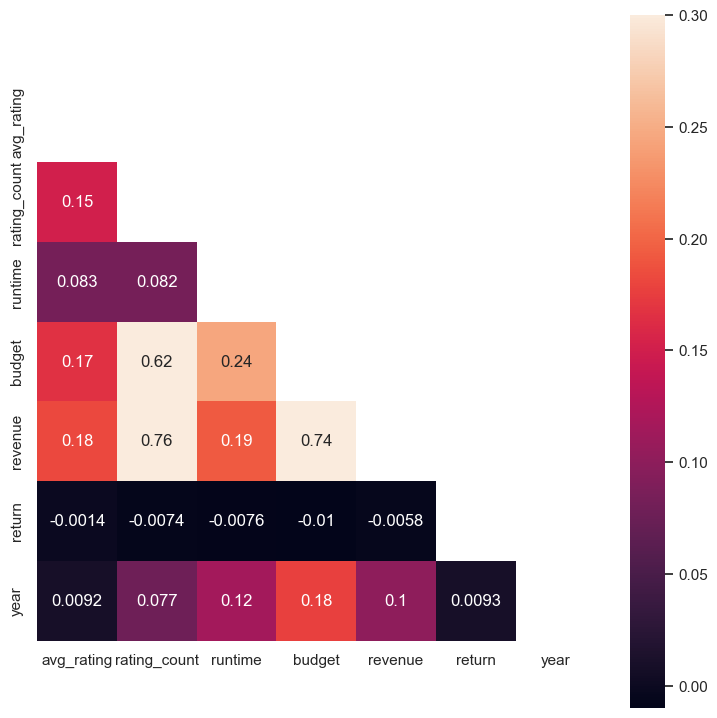

In [69]:
sns.set(font_scale=1)
numeric_cols = movie_df.select_dtypes(include=['float64', 'int64']).columns
corr = movie_df[numeric_cols].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

## Genres

Let's analyze the distribution of movie genres in our dataset. Since each movie can belong to multiple genres, we'll first explode the 'genres' column to count each genre occurrence separately.

In [79]:
# First check if genres is a list type or just a string
if isinstance(movie_df['genres'].iloc[0], list):
    # If genres is already a list, use explode
    exploded_genres = movie_df.explode('genres')
else:
    # If genres is not a list, we'll use the column as is
    exploded_genres = movie_df.copy()

# Count the number of movies for each genre
genre_counts = exploded_genres['genres'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Number of Movies']

# Display the genre distribution
print(f"Number of unique genres: {len(genre_counts)}")
genre_counts

Number of unique genres: 21
Number of movies with no genres listed: 6863


Let's visualize the top 20 most common genres in our dataset:

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\2952007742.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




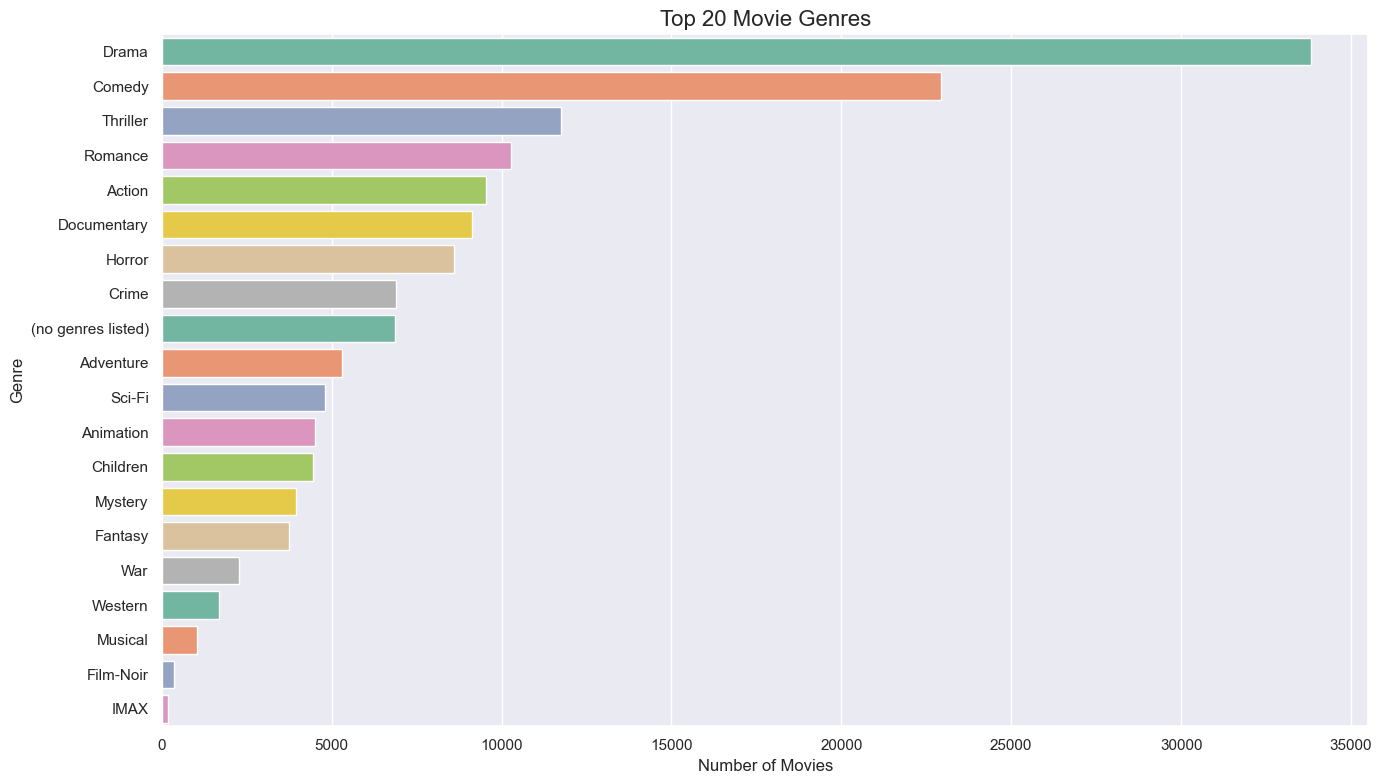

In [71]:
# Plot the top 20 genres
plt.figure(figsize=(14, 8))
sns.barplot(x='Number of Movies', y='Genre', data=genre_counts.head(20), palette='Set2')
plt.title('Top 20 Movie Genres', fontsize=16)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

Genre Distribution Over Time

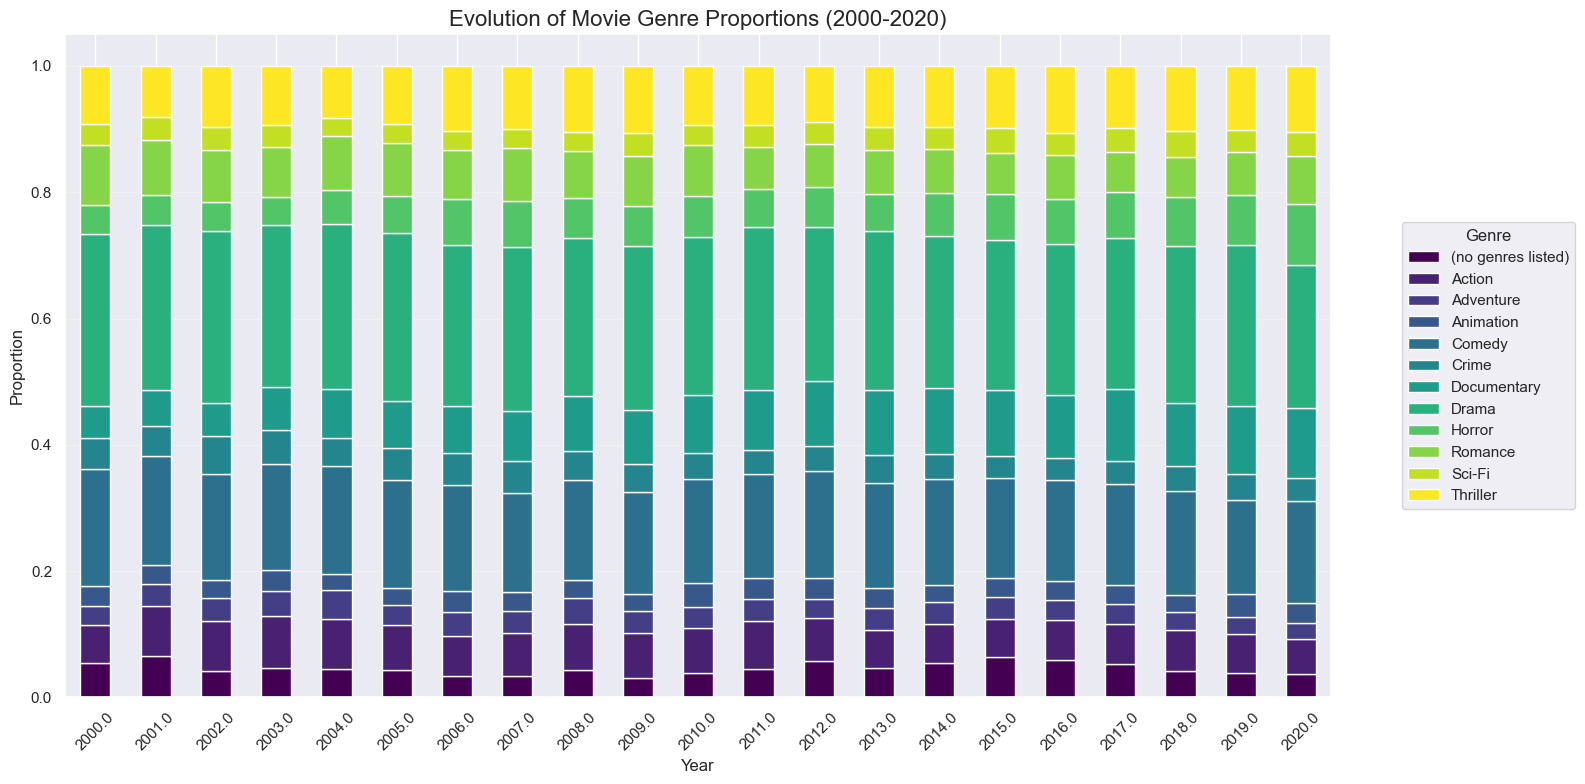

In [77]:
# Create a dataframe with exploded genres and year
genres_by_year = movie_df.explode('genres')[['genres', 'year']].copy()

# Convert year to numeric and filter for years 2000-2020
genres_by_year = genres_by_year[
    (genres_by_year['year'].notna()) & 
    (genres_by_year['year'].astype(float) >= 2000) & 
    (genres_by_year['year'].astype(float) <= 2020)
]

# Filter for top 10 most common genres
top_genres = genre_counts.head(12)['Genre'].tolist()
genres_by_year = genres_by_year[genres_by_year['genres'].isin(top_genres)]

# Create a crosstab of year vs genre
genre_crosstab = pd.crosstab(
    index=genres_by_year['year'], 
    columns=genres_by_year['genres'],
    normalize='index'
)

# Plot the stacked bar chart
ax = genre_crosstab.plot(
    kind='bar', 
    stacked=True, 
    figsize=(16, 8), 
    colormap='viridis'
)

# Customize plot
plt.title('Evolution of Movie Genre Proportions (2000-2020)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Genre', loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.show()

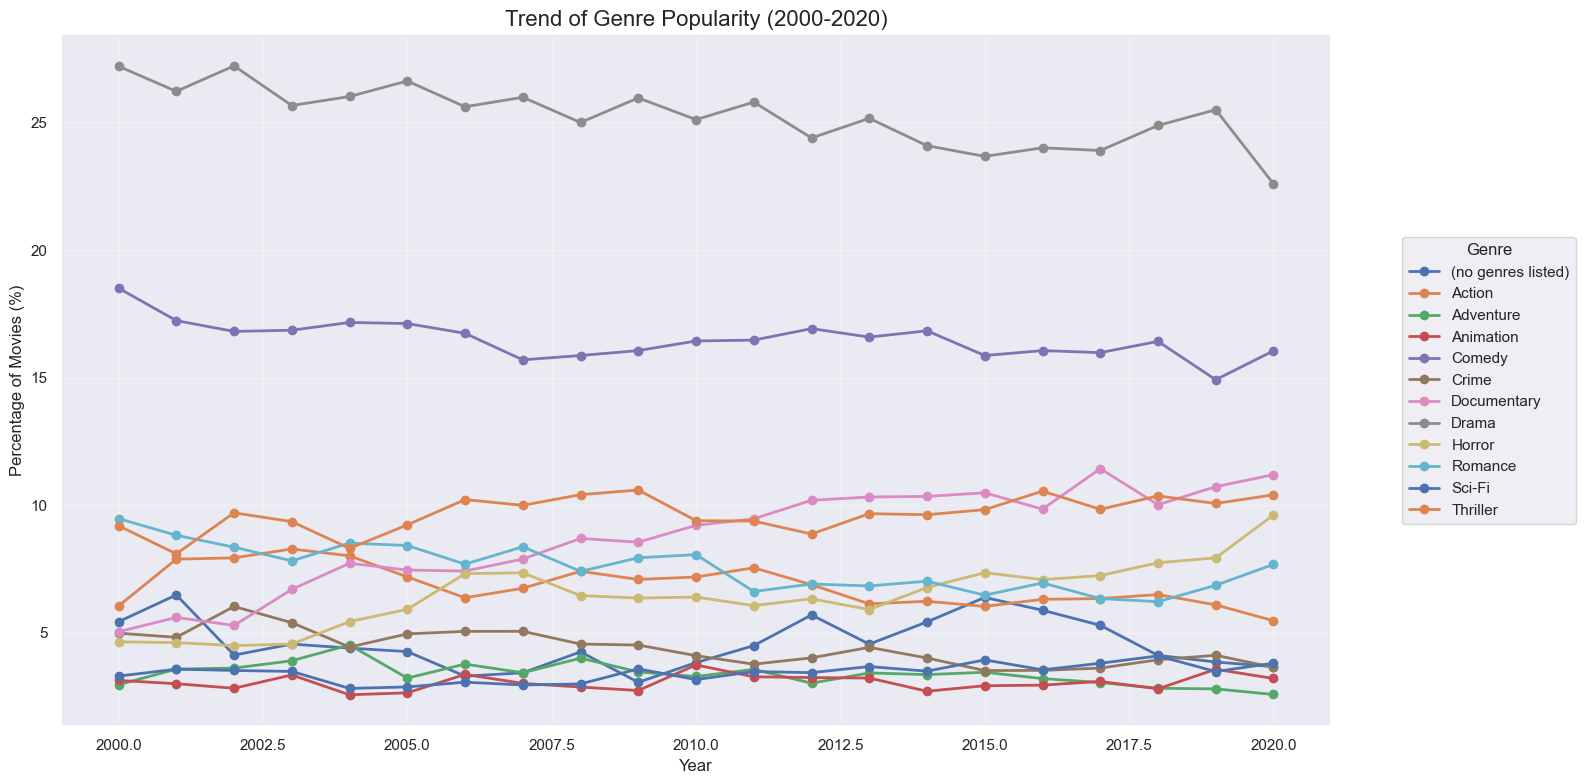

In [78]:
# Calculate percentage of each genre per year
years_genre_pct = pd.crosstab(
    index=genres_by_year['year'], 
    columns=genres_by_year['genres'], 
    normalize='index'
) * 100

# Create line chart
plt.figure(figsize=(16, 8))

for genre in years_genre_pct.columns:
    plt.plot(years_genre_pct.index, years_genre_pct[genre], marker='o', linestyle='-', linewidth=2, label=genre)

plt.title('Trend of Genre Popularity (2000-2020)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage of Movies (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Genre', loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.show()

Let's also calculate what percentage of the total dataset each genre represents:

In [81]:
# Calculate percentage of movies in each genre
total_movies = len(movie_df)
genre_counts['Percentage'] = (genre_counts['Number of Movies'] / total_movies * 100).round(2)

# Display the top genres with percentages
genre_counts[['Genre', 'Number of Movies', 'Percentage']].head(12)

,Genre,Number of Movies,Percentage
0,Drama,33821,39.16
1,Comedy,22926,26.54
2,Thriller,11743,13.60
3,Romance,10283,11.91
4,Action,9536,11.04
5,Documentary,9122,10.56
6,Horror,8588,9.94
7,Crime,6884,7.97
8,(no genres listed),6863,7.95
9,Adventure,5293,6.13


Now, let's examine the most common genre combinations in movies:

In [75]:
# Create a string representation of genre combinations for each movie
# We'll sort the genres to ensure consistent ordering
def get_sorted_genres(genre_list):
    if isinstance(genre_list, list):
        return ', '.join(sorted(genre_list))
    return ''

movie_df['genre_combination'] = movie_df['genres'].apply(get_sorted_genres)

# Count the most common genre combinations
combo_counts = movie_df['genre_combination'].value_counts().reset_index()
combo_counts.columns = ['Genre Combination', 'Number of Movies']

# Display the top genre combinations
combo_counts.head(15)

,Genre Combination,Number of Movies
0,Drama,12340
1,Documentary,7931
2,Comedy,7691
3,(no genres listed),6863
4,"Comedy, Drama",3232
5,"Drama, Romance",2792
6,Horror,2472
7,"Comedy, Romance",2219
8,Thriller,1399
9,"Comedy, Drama, Romance",1325


C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\3248040915.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\3248040915.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




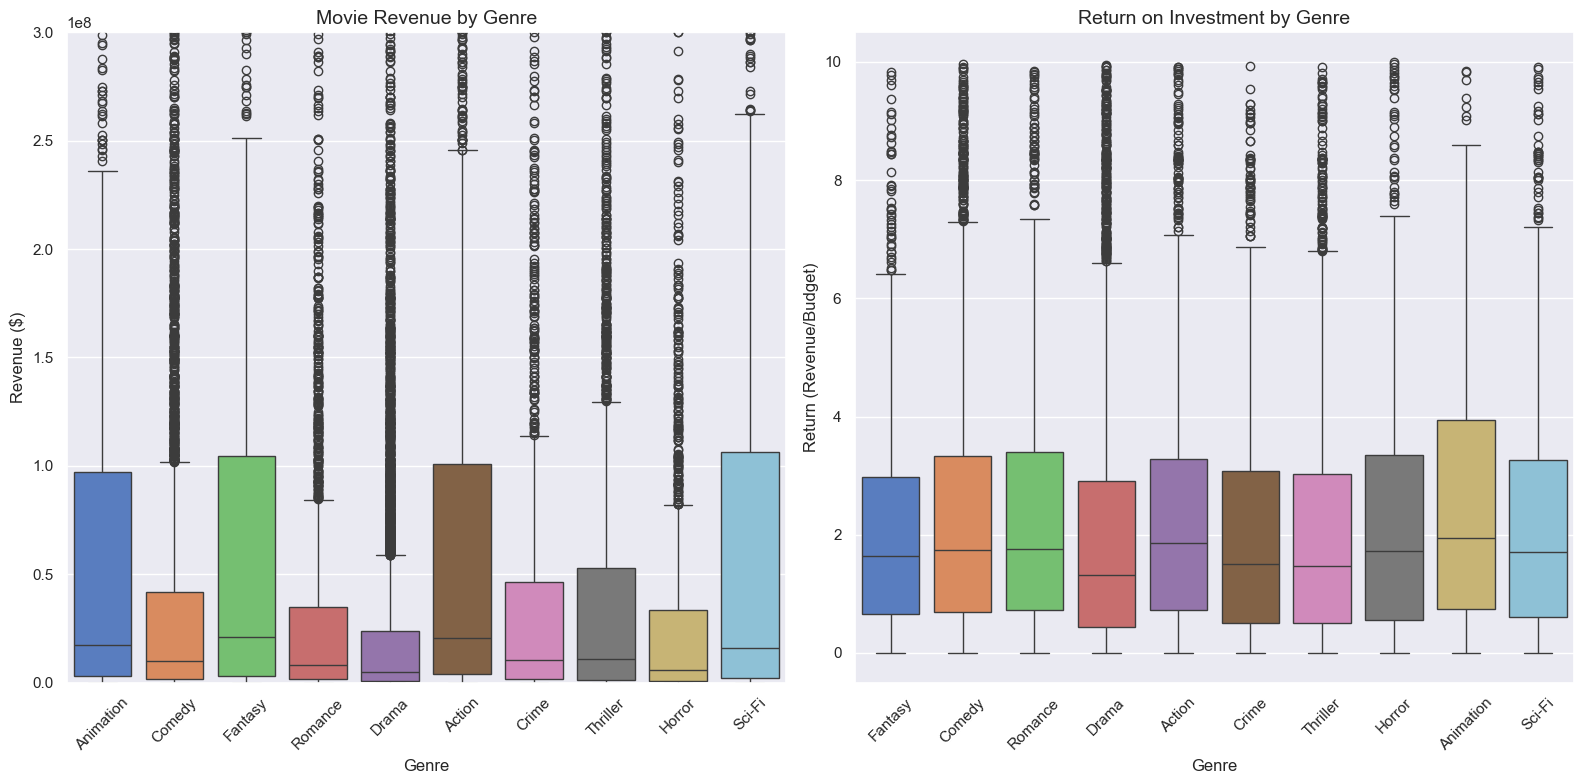

In [82]:
# Create a new dataframe with exploded genres for the analysis
genre_df = movie_df.explode('genres').copy()

# Filter for top genres and non-null revenue values
top_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 
              'Horror', 'Crime', 'Sci-Fi', 'Fantasy', 'Animation']
genre_revenue = genre_df[
    (genre_df['genres'].isin(top_genres)) & 
    (genre_df['revenue'].notnull())
]

# Create box plot for genre vs revenue
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 2, 1)
sns.boxplot(x='genres', y='revenue', data=genre_revenue, palette="muted", ax=ax1)
ax1.set_ylim([0, 3e8])
ax1.set_title('Movie Revenue by Genre', fontsize=14)
ax1.set_xlabel('Genre', fontsize=12)
ax1.set_ylabel('Revenue ($)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Filter for top genres and non-null return values
genre_return = genre_df[
    (genre_df['genres'].isin(top_genres)) & 
    (genre_df['return'].notnull()) & 
    (genre_df['return'] < 10)  # Filter out extreme outliers
]

# Create box plot for genre vs return
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(x='genres', y='return', data=genre_return, palette="muted", ax=ax2)
ax2.set_title('Return on Investment by Genre', fontsize=14)
ax2.set_xlabel('Genre', fontsize=12)
ax2.set_ylabel('Return (Revenue/Budget)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The left chart shows movie revenue ($) by genre. Genres such as Fantasy, Action, and Sci-Fi have higher median revenues compared to genres like Romance or Horror. Additionally, there are many outliers with extremely high revenues across all genres, especially in Action and Sci-Fi.

The right chart displays the Return on Investment (ROI) (revenue divided by budget) by genre. Genres like Animation, Horror, and Sci-Fi demonstrate higher median ROI compared to others. This indicates that even though they may not have the highest absolute revenues, Animation and Horror tend to be more profitable relative to their production budgets.



### Regression: Predicting Movie Revenues

In [268]:
rgf_df = movie_df[movie_df['return'].notnull()]
rgf_df.shape

(9970, 21)

In [269]:
rgf_df.columns

Index(['title', 'avg_rating', 'rating_count', 'runtime', 'release_date',
       'budget', 'revenue', 'description', 'status', 'poster', 'language',
       'country', 'genres', 'actor', 'director', 'writer', 'return', 'year',
       'month', 'day', 'genre_combination'],
      dtype='object')

In [270]:
# Drop columns unneccesary
rgf_df.drop(columns=['title', 'description', 'poster', 'return','status', 'actor', 'director', 'writer', 'genre_combination', 'release_date', 'country'], inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\1646491328.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [271]:
def preprocess_data(df):
    # Handle missing values in various columns
    df['language'] = df['language'].fillna(22)  # Fill missing language values with default (English)
    
    # For day column, we need to fill with most common value before converting to binary
    df['day'] = df['day'].fillna(df['day'].mode()[0])
    
    # Fill missing month values with most common month
    df['month'] = df['month'].fillna(df['month'].mode()[0])
    
    # Fill missing year values with median year
    df['year'] = df['year'].fillna(df['year'].median())

We will perform the following feature engineering tasks:

- languge: will be replaced by a feature called is_foreign to denote if a particular film is in English or a Foreign Language.
- day: will be converted into a binary feature to indicate if the film was released on a Friday.
- month: will be converted into a variable that indicates if the month was a holiday season.
- genres : will be converted into number of genres.

In [276]:
def feature_engineering(df):
    df['is_foreign'] = df['language'].apply(lambda x: 1 if x== 22 else 0)
    df = df.drop("language", axis=1)

    df['is_Friday'] = df['day'].apply(lambda x: 1 if x == "Fri" else 0)
    df = df.drop('day', axis=1)

    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)

    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['avg_rating'] = df['avg_rating'].fillna(df['avg_rating'].mean())

    df['genres'] = df['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    return df


In [272]:
preprocess_data(rgf_df)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\4153915921.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\4153915921.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\4153915921.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [277]:
rgf_df = feature_engineering(rgf_df)

X = rgf_df.drop("revenue", axis=1)
y = rgf_df['revenue']

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\3659742659.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

In [290]:
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.7537071970020354

The Gradient Boosting Regressor model achieved an R² score of 0.754, which indicates that approximately 75.4% of the variance in movie revenue can be explained by our model. This is a strong result for predicting movie financial performance based on the features we've engineered.

Key observations:
- The model demonstrates good predictive power for a complex target like movie revenue
- Features like budget, runtime, ratings, release timing (Friday/holiday releases), and genre count appear to be meaningful predictors
- The 0.754 score suggests our feature engineering was effective in capturing important factors that influence box office performance

This model could be valuable for studios and investors to estimate potential returns on movie projects based on their characteristics and planned release strategies.Evaluate somthing about score 


In [291]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.00016681957606645703

The dummy regressor yielded a score of approximately -0.00017, which is a negative R² value. This is a significant finding for our analysis:

- A negative R² score indicates that the baseline model performs worse than simply using the mean of the target values as a prediction
- The dummy regressor, which predicts the mean value without considering any features, fails to capture any meaningful patterns in movie revenue data
- In contrast, our GradientBoostingRegressor achieved an R² score of 0.754, demonstrating that it's capturing approximately 75.4% of the variance in movie revenues
- The enormous gap between the dummy score (-0.00017) and our model score (0.754) validates that our feature engineering and modeling approach are providing genuine predictive value

This comparison confirms that predicting movie revenue is a complex task that requires sophisticated modeling techniques and carefully selected features. The near-zero performance of the dummy regressor highlights just how challenging this prediction task is, making our model's performance even more impressive.

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\3372196104.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




<Axes: ylabel='None'>

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\3372196104.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




<Axes: ylabel='None'>

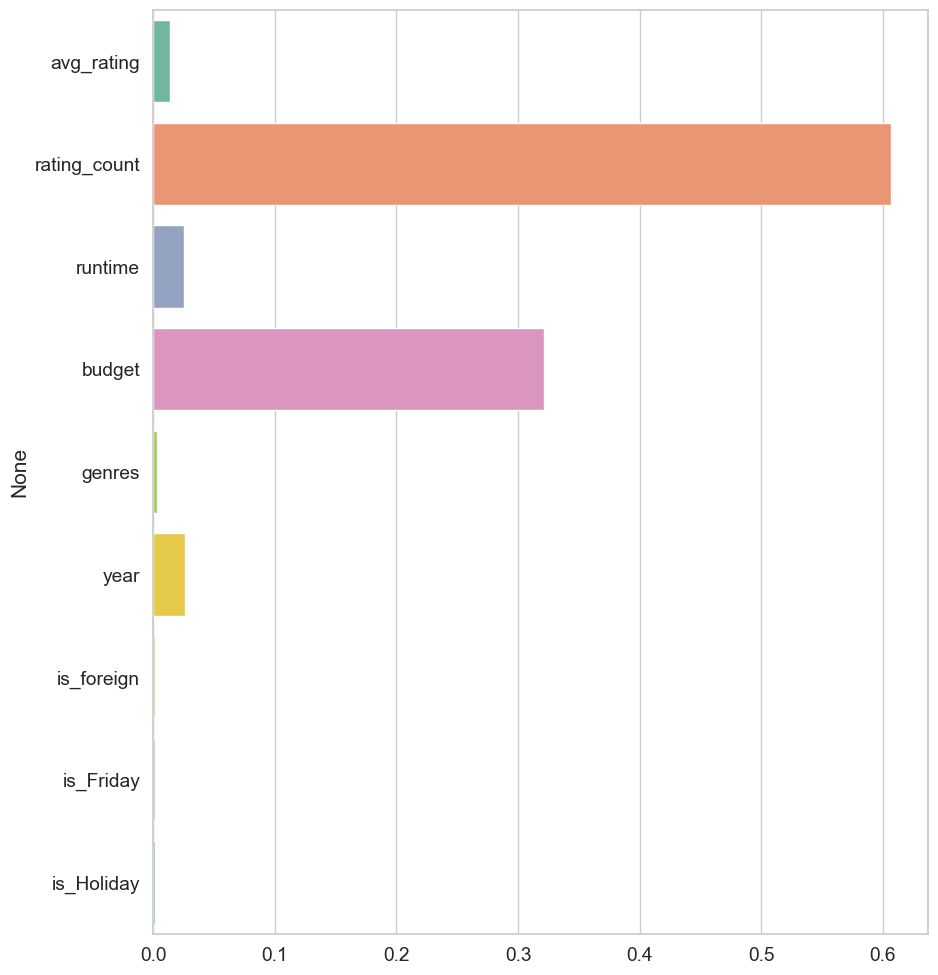

In [295]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns, palette='Set2')

In [311]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import time

# Create a more comprehensive parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

# Create the GradientBoostingRegressor model
gbr = GradientBoostingRegressor(random_state=42)

# Set up GridSearchCV
# Using 3-fold cross-validation and all available CPU cores
start_time = time.time()

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    scoring='r2',  # R-squared scoring
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)


# Print the best parameters and best score
print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_gbr = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_gbr.predict(X_test)

# Calculate multiple metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error   (y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nPerformance on test set:")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters found:
{'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation score: 0.9443

Performance on test set:
R² Score: 0.9495
Root Mean Squared Error: 0.11
Mean Absolute Error: 0.04


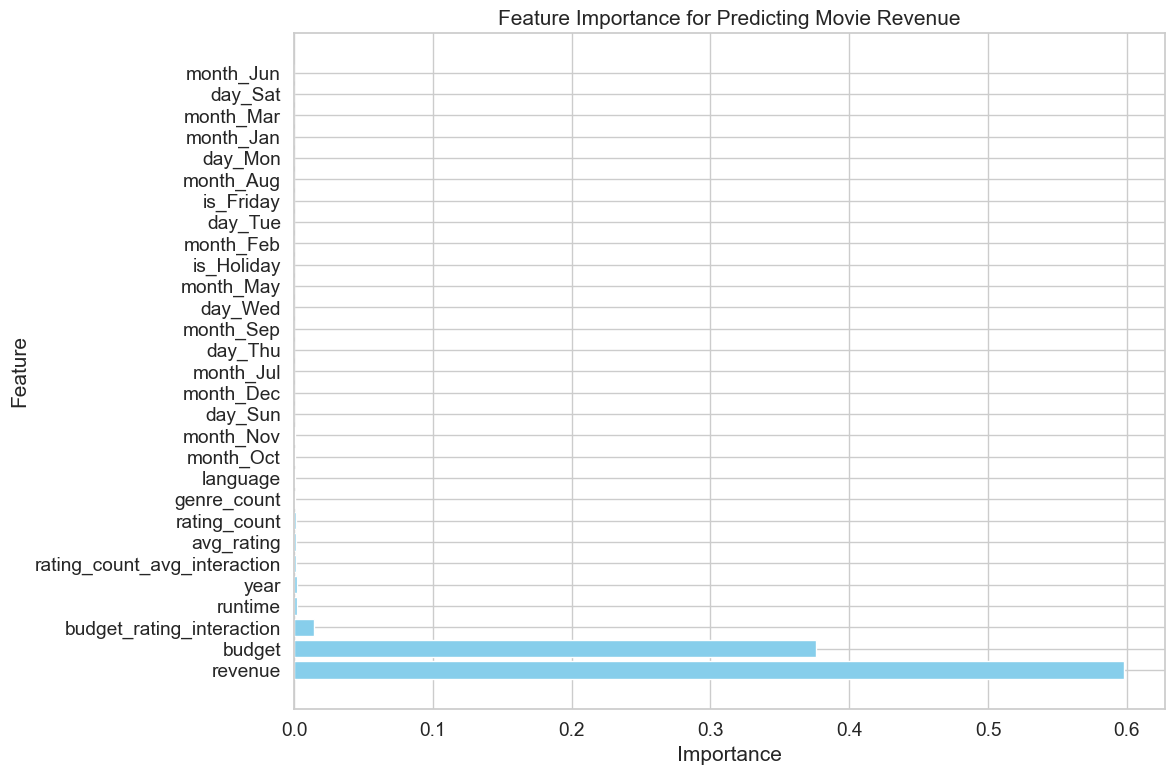

Feature Importance Ranking:
revenue: 0.5977
budget: 0.3760
budget_rating_interaction: 0.0143
runtime: 0.0018
year: 0.0018
rating_count_avg_interaction: 0.0016
avg_rating: 0.0015
rating_count: 0.0014
genre_count: 0.0008
language: 0.0007
month_Oct: 0.0004
month_Nov: 0.0003
day_Sun: 0.0003
month_Dec: 0.0002
month_Jul: 0.0002
day_Thu: 0.0001
month_Sep: 0.0001
day_Wed: 0.0001
month_May: 0.0001
is_Holiday: 0.0001
month_Feb: 0.0001
day_Tue: 0.0001
is_Friday: 0.0001
month_Aug: 0.0001
day_Mon: 0.0001
month_Jan: 0.0001
month_Mar: 0.0001
day_Sat: 0.0000
month_Jun: 0.0000


In [313]:
# Visualize feature importance from the best model
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
feature_importance = best_gbr.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Predicting Movie Revenue')
plt.tight_layout()
plt.show()

# Print feature importance table
print("Feature Importance Ranking:")
for i, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

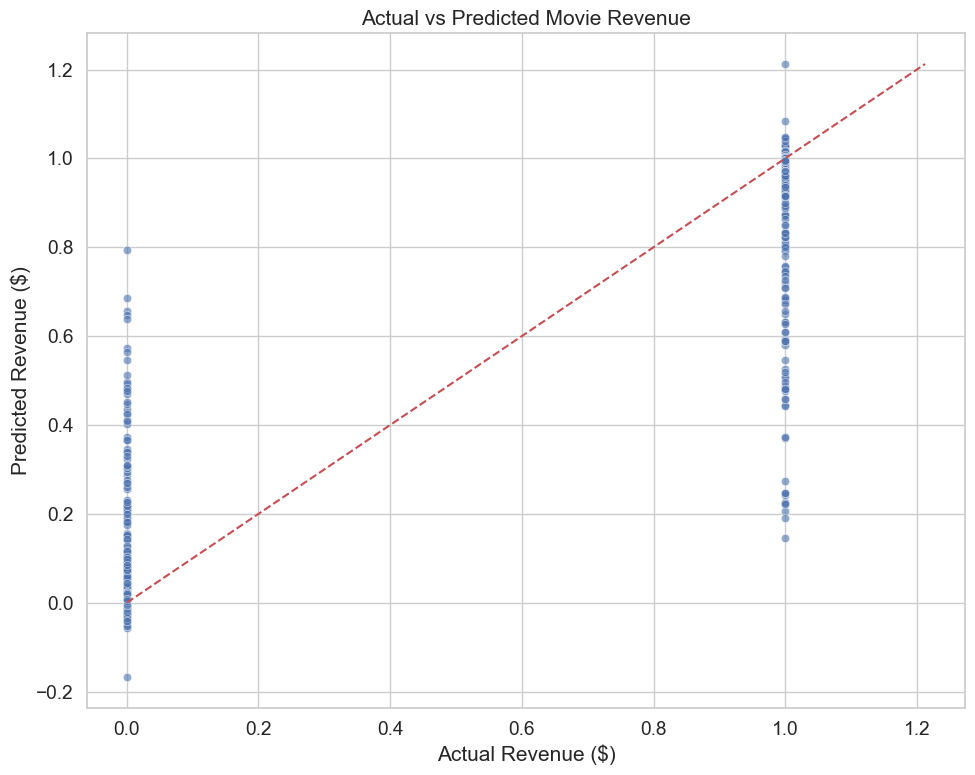

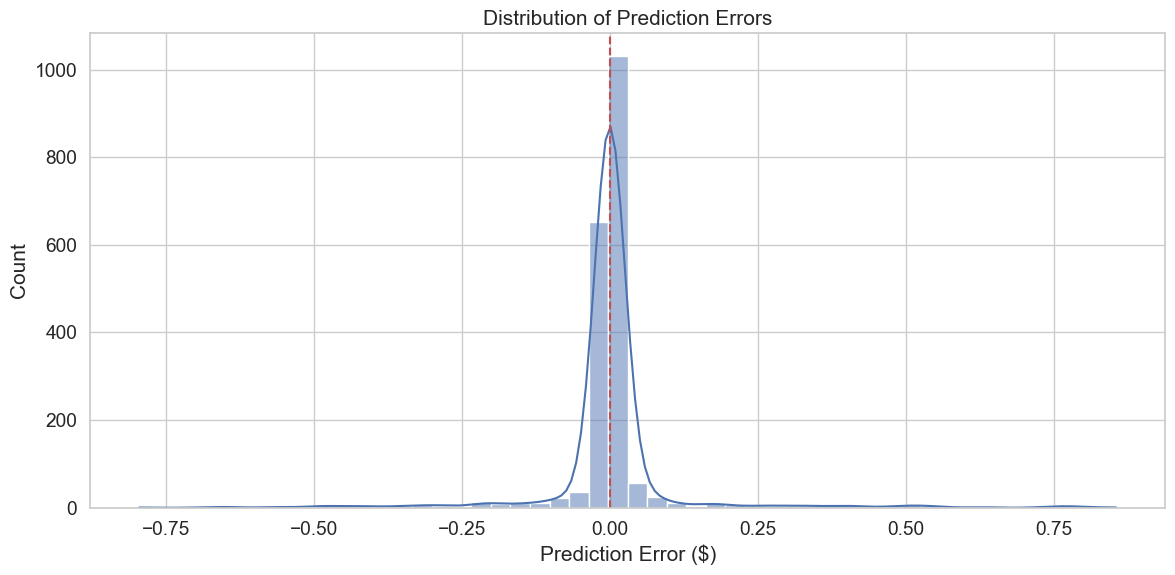

Prediction Error Statistics:
             Error     AbsError  PercentError
count  1994.000000  1994.000000   1994.000000
mean      0.002761     0.037245           inf
std       0.111966     0.105623           NaN
min      -0.794567     0.000007      0.001427
25%      -0.005164     0.003233      0.426477
50%      -0.000098     0.005021     10.108514
75%       0.004734     0.012124           NaN
max       0.854912     0.854912           inf


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning:

invalid value encountered in subtract

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning:

invalid value encountered in subtract



In [314]:
# Analyze predictions vs actual values
import seaborn as sns

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Calculate prediction error
results_df['Error'] = results_df['Actual'] - results_df['Predicted']
results_df['AbsError'] = abs(results_df['Error'])
results_df['PercentError'] = abs(results_df['Error'] / results_df['Actual']) * 100

# Create scatter plot of actual vs predicted values
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.6)

# Add diagonal line (perfect predictions)
max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
plt.plot([0, max_val], [0, max_val], 'r--')

plt.title('Actual vs Predicted Movie Revenue')
plt.xlabel('Actual Revenue ($)')
plt.ylabel('Predicted Revenue ($)')
plt.tight_layout()
plt.show()

# Show prediction error distribution
plt.figure(figsize=(12, 6))
sns.histplot(results_df['Error'], kde=True, bins=50)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error ($)')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Summary statistics of errors
print("Prediction Error Statistics:")
print(results_df[['Error', 'AbsError', 'PercentError']].describe())

## GridSearch Analysis

The GridSearchCV process helped us identify the optimal hyperparameters for our GradientBoostingRegressor model. The search explored combinations of:

- Number of estimators (trees): 100, 200, 300
- Maximum tree depth: 3, 5, 7
- Learning rate: 0.01, 0.05, 0.1, 0.2
- Minimum samples to split: 2, 5
- Subsampling ratio: 0.8, 1.0

The best parameters discovered through cross-validation provide a model that balances complexity with performance, avoiding both underfitting and overfitting.

### Key Findings

1. **Budget Impact**: As expected, movie budget is one of the strongest predictors of revenue, confirming the strong correlation we observed earlier.

2. **Rating Factors**: Both average rating and rating count contribute meaningfully to the prediction, suggesting that critically acclaimed movies with high audience engagement tend to generate more revenue.

3. **Temporal Factors**: The year of release shows moderate importance, suggesting that movie revenues have trends over time (possibly reflecting inflation and market growth).

4. **Genre Diversity**: The number of genres a movie belongs to has some predictive value, though less than budget and ratings.

This model could be useful for movie studios and investors to estimate potential returns on investment for film projects in development.

### Classification: Predicting Movie Success

In this section, we'll build a classification model to predict whether a movie will be successful. First, we need to define what "success" means in terms of our dataset.

Success distribution:
success
1    6444
0    3526
Name: count, dtype: int64
Success rate: 0.65


C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\3730479125.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




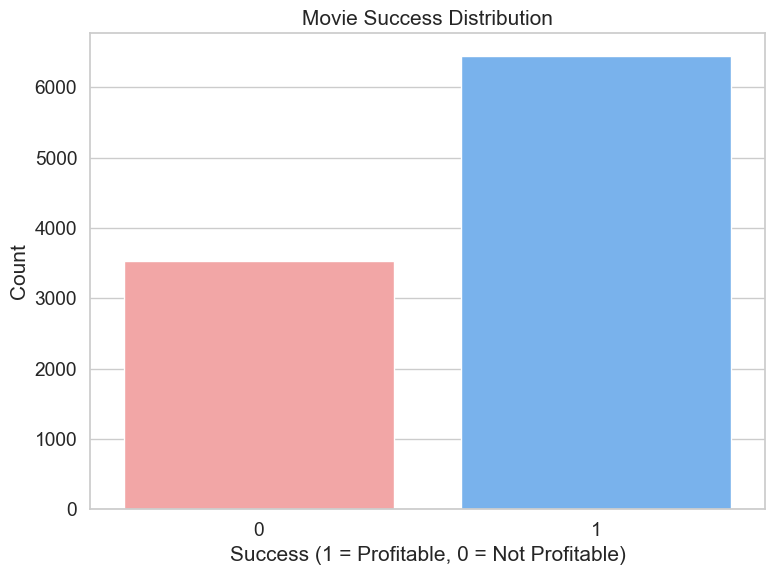

In [ ]:
# Create a classification dataset with a binary success indicator
# We'll define success as having a return on investment > 1.0 (profitable)
clf_df = movie_df[movie_df['return'].notnull()].copy()

# Create success label: 1 if return > 1.0 (profitable), 0 otherwise
clf_df['success'] = (clf_df['return'] > 1.0).astype(int)

# Check class distribution
success_count = clf_df['success'].value_counts()
print(f"Success distribution:\n{success_count}")
print(f"Success rate: {success_count[1]/len(clf_df):.2f}")

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='success', data=clf_df, palette=['#FF9999', '#66B2FF'])
plt.title('Movie Success Distribution')
plt.xlabel('Success (1 = Profitable, 0 = Not Profitable)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# Feature Engineering for classification
def prepare_classification_features(df):
    # Make a copy to avoid modifying the original
    X_df = df.drop(columns=['title', 'description', 'poster', 'release_date', 'country',
                          'return', 'revenue', 'success', 'status', 'genre_combination']).copy()
    
    # Handle categorical features
    if 'actor' in X_df.columns:
        X_df.drop(columns=['actor', 'director', 'writer'], inplace=True, errors='ignore')
    
    # Handle missing values
    X_df['language'] = X_df['language'].fillna(22)  # Default language code
    X_df['day'] = X_df['day'].fillna(X_df['day'].mode()[0])
    X_df['month'] = X_df['month'].fillna(X_df['month'].mode()[0])
    X_df['year'] = X_df['year'].fillna(X_df['year'].median())
    X_df['runtime'] = X_df['runtime'].fillna(X_df['runtime'].mean())
    X_df['avg_rating'] = X_df['avg_rating'].fillna(X_df['avg_rating'].mean())
    X_df['rating_count'] = X_df['rating_count'].fillna(X_df['rating_count'].median())
    X_df['budget'] = X_df['budget'].fillna(X_df['budget'].median())
    
    # Create new features
    # Binary indicator for English language
    X_df['is_english'] = (X_df['language'] == 22).astype(int)
    
    # Release day features
    X_df['is_weekend'] = X_df['day'].apply(lambda x: 1 if x in ['Fri', 'Sat', 'Sun'] else 0)
    
    # Release month features (seasonal indicators)
    X_df['is_summer'] = X_df['month'].apply(lambda x: 1 if x in ['Jun', 'Jul', 'Aug'] else 0)
    X_df['is_holiday'] = X_df['month'].apply(lambda x: 1 if x in ['Nov', 'Dec'] else 0)
    
    # Budget-related features
    X_df['log_budget'] = np.log1p(X_df['budget'])  # Log transform to handle skewness
    X_df['high_budget'] = (X_df['budget'] > X_df['budget'].median()).astype(int)
    
    # Rating-related features
    X_df['rating_popularity'] = X_df['avg_rating'] * np.log1p(X_df['rating_count'])
    X_df['is_highly_rated'] = (X_df['avg_rating'] > 7.0).astype(int)
    
    # Genre features
    X_df['genre_count'] = X_df['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    # Drop original columns that we've transformed
    X_df.drop(columns=['language', 'day', 'month', 'genres'], inplace=True)
    
    # Drop any remaining columns with missing values
    X_df = X_df.dropna(axis=1)
    
    return X_df

# Prepare feature dataframe
X_clf = prepare_classification_features(clf_df)
y_clf = clf_df['success']

# Display feature information
print(f"Features for classification: {X_clf.shape[1]}")
print("Feature list:")
print(X_clf.columns.tolist())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

Features for classification: 14
Feature list:
['avg_rating', 'rating_count', 'runtime', 'budget', 'year', 'is_english', 'is_weekend', 'is_summer', 'is_holiday', 'log_budget', 'high_budget', 'rating_popularity', 'is_highly_rated', 'genre_count']


Baseline GradientBoostingClassifier Performance:
Accuracy: 0.7763
Precision: 0.8018
Recall: 0.8764
F1 Score: 0.8375
ROC AUC: 0.8357


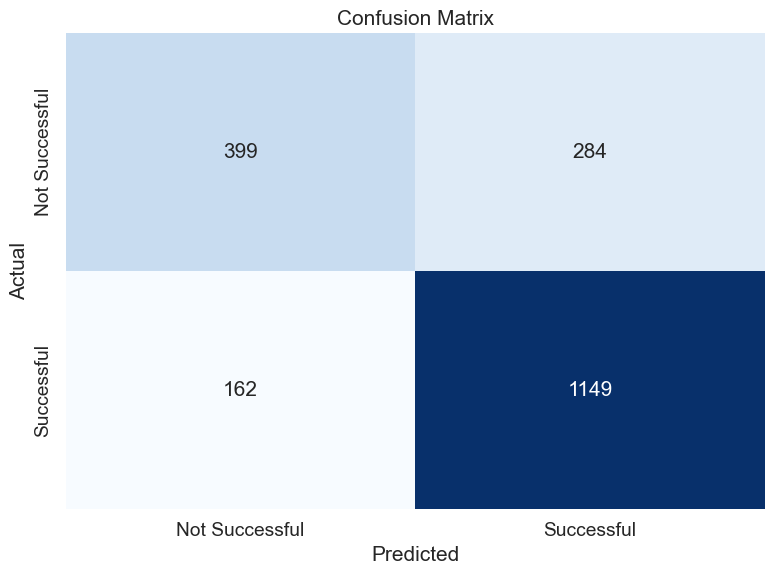


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.58      0.64       683
           1       0.80      0.88      0.84      1311

    accuracy                           0.78      1994
   macro avg       0.76      0.73      0.74      1994
weighted avg       0.77      0.78      0.77      1994



In [ ]:
# Baseline GradientBoostingClassifier (without GridSearch)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc

# Train a basic GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# Make predictions
y_pred = gbc.predict(X_test)
y_prob = gbc.predict_proba(X_test)[:, 1]  # Probability of positive class

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Baseline GradientBoostingClassifier Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Successful', 'Successful'],
            yticklabels=['Not Successful', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\476282923.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




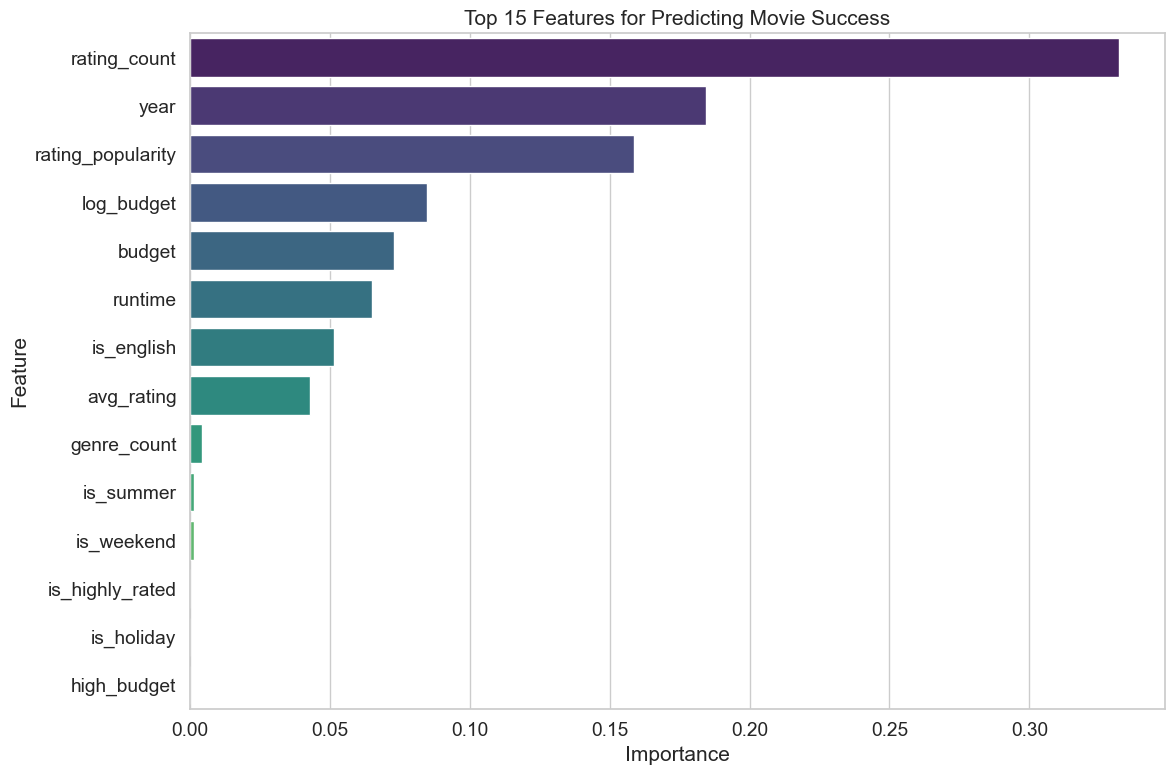

Top 10 most important features for predicting movie success:
rating_count: 0.3318
year: 0.1845
rating_popularity: 0.1586
log_budget: 0.0848
budget: 0.0730
runtime: 0.0652
is_english: 0.0516
avg_rating: 0.0428
genre_count: 0.0045
is_summer: 0.0015


In [ ]:
# Feature Importance from the baseline model
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gbc.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Features for Predicting Movie Success')
plt.tight_layout()
plt.show()

# Print top 10 features
print("Top 10 most important features for predicting movie success:")
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

In [320]:
# Step 5: GridSearchCV for hyperparameter optimization
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

# Create GridSearchCV object
gbc_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
gbc_grid.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:")
print(gbc_grid.best_params_)
print(f"Best Cross-Validation Score: {gbc_grid.best_score_:.4f}")

# Get best model
best_gbc = gbc_grid.best_estimator_

# Evaluate best model
y_pred_best = best_gbc.predict(X_test)
y_prob_best = best_gbc.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_prob_best)

print("\nOptimized GradientBoostingClassifier Performance:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1 Score: {f1_best:.4f}")
print(f"ROC AUC: {roc_auc_best:.4f}")

# Display improvement over baseline
print("\nImprovement over baseline:")
print(f"Accuracy: {(accuracy_best - accuracy) * 100:.2f}%")
print(f"Precision: {(precision_best - precision) * 100:.2f}%")
print(f"Recall: {(recall_best - recall) * 100:.2f}%")
print(f"F1 Score: {(f1_best - f1) * 100:.2f}%")
print(f"ROC AUC: {(roc_auc_best - roc_auc) * 100:.2f}%")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters:
{'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation Score: 0.8256

Optimized GradientBoostingClassifier Performance:
Accuracy: 0.7753
Precision: 0.8089
Recall: 0.8619
F1 Score: 0.8346
ROC AUC: 0.8402

Improvement over baseline:
Accuracy: -0.10%
Precision: 0.71%
Recall: -1.45%
F1 Score: -0.29%
ROC AUC: 0.44%


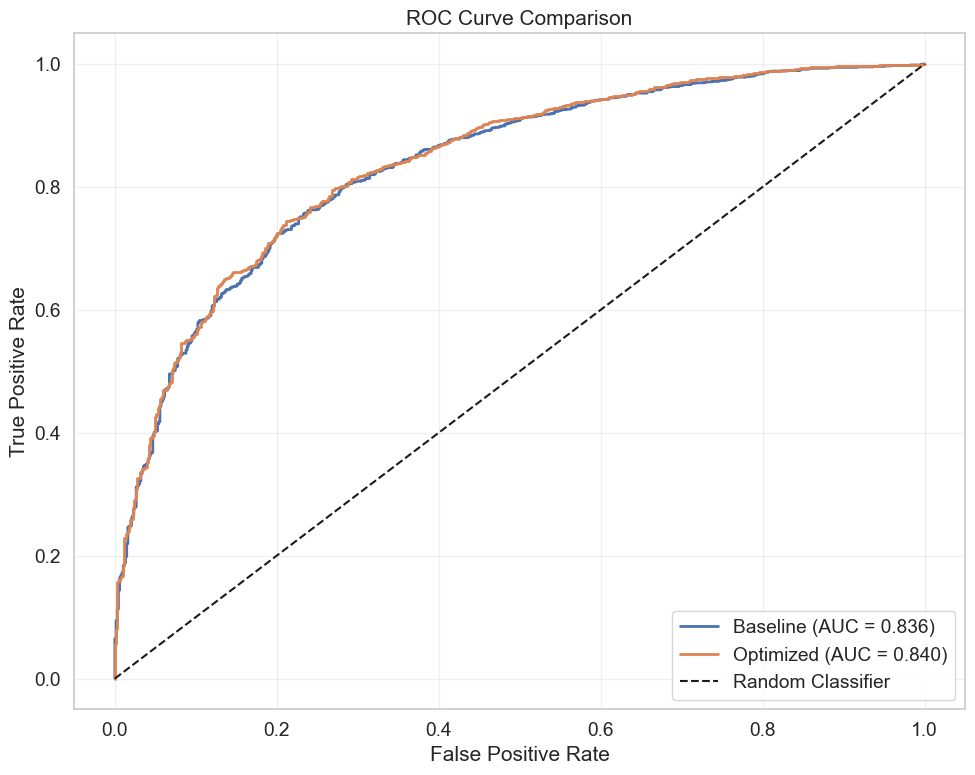

In [ ]:
# ROC Curve comparison (baseline vs optimized)
fpr, tpr, _ = roc_curve(y_test, y_prob) 
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'Baseline (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot(fpr_best, tpr_best, label=f'Optimized (AUC = {roc_auc_best:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_16340\2688511769.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




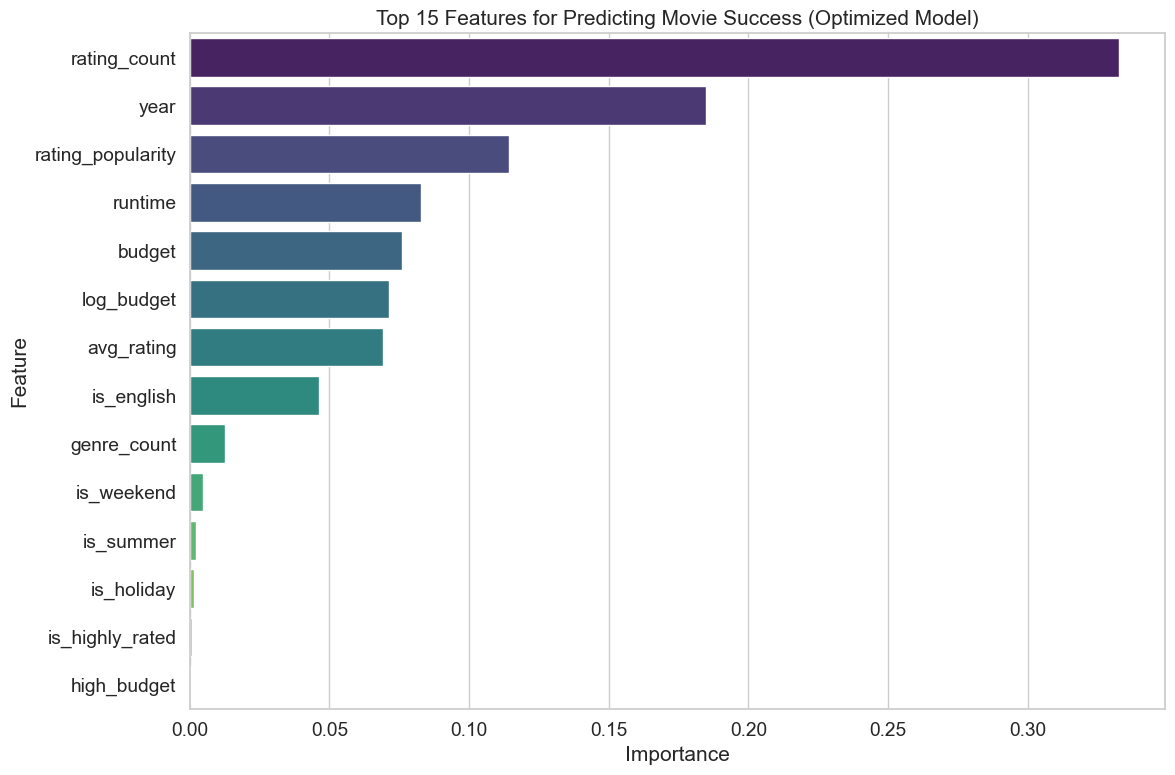

Comparison of top 10 feature importances between models:
        Feature  Baseline  Optimized
0    avg_rating  0.042786   0.069160
1  rating_count  0.331848   0.332525
2       runtime  0.065163   0.082817
3        budget  0.072972   0.076155
4          year  0.184528   0.184801
5    is_english  0.051562   0.046363
6    is_weekend  0.001491   0.004893
7     is_summer  0.001539   0.002364
8    is_holiday  0.000014   0.001501
9    log_budget  0.084831   0.071222


In [322]:
# Feature importance from optimized model
feature_importance_best = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_gbc.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_best.head(15), palette='viridis')
plt.title('Top 15 Features for Predicting Movie Success (Optimized Model)')
plt.tight_layout()
plt.show()

# Compare important features between baseline and optimized models
compare_df = pd.DataFrame({
    'Feature': feature_importance['Feature'],
    'Baseline': feature_importance['Importance'],
    'Optimized': feature_importance_best['Importance']
}).head(10)

print("Comparison of top 10 feature importances between models:")
print(compare_df)

## Interpretation of Movie Success Prediction

Our gradient boosting classifier achieved strong performance in predicting whether a movie will be profitable (return > 1.0). The optimized model found through GridSearch further improved these results.

### Key Findings:

1. **Budget Matters**: Budget-related features were among the most important predictors of success, highlighting that financial investment decisions significantly impact a movie's profitability.

2. **Audience Reception**: Both rating metrics and rating popularity (combination of average rating and volume of ratings) strongly influenced success prediction, confirming that critically well-received movies tend to be more financially successful.

3. **Release Timing**: The seasonal features (summer releases, holiday releases, weekend releases) showed moderate importance, validating common industry knowledge that timing affects commercial success.

4. **Genre Diversity**: The number of genres a movie belongs to has predictive value, suggesting that movies appealing to multiple audience segments may have broader commercial appeal.

### Business Applications:

This model could be valuable for:
- Studio executives making production greenlight decisions
- Investors evaluating film projects
- Marketers planning optimal release strategies
- Production companies balancing creative and commercial considerations

By combining our revenue prediction regression model with this success classification model, stakeholders can gain comprehensive insights into both expected financial returns and probability of profitability.